In [6]:
%%capture
!pip install ffmpeg-python
!pip install joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import joblib
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.chdir("/content/drive/MyDrive/Audiofiles")

In [5]:
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

In [9]:
#function for getting ravdess dataset details and labeling
def ravdess_data():
  #directory of the audio dataset
  ravdess = "/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "/content/drive/MyDrive/Audiofiles/AudioWAV/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema

#function for getting tess dataset and labeling
def tess_data():
  #directory of the audio dataset
  tess = "/content/drive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
  tess_emotion = []
  tess_path = []
  tess_folder = os.listdir(tess)
  for i in tess_folder:
    emotion = i.split('_',1)[1]
    inner_files = os.listdir(tess+i+'/')
    for j in inner_files:
      tess_path.append(tess+i+'/'+j)
      tess_emotion.append(emotion)

  #convert to dataframe
  df_tess = pd.DataFrame([tess_path,tess_emotion]).T
  df_tess.columns = ["AudioPath","Label"]
  print("length of tess dataset",len(df_tess))

  return df_tess

#function to get savee dataset and labeling
def saveee_data():
  #directory of the audio dataset
  savee = "/content/drive/MyDrive/Audiofiles/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)

  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee

In [10]:
ravdess_data()

length of ravdess dataset 1440


AudioPath      Label
0     /content/drive/MyDrive/Audiofiles/audio_speech...    neutral
1     /content/drive/MyDrive/Audiofiles/audio_speech...    neutral
2     /content/drive/MyDrive/Audiofiles/audio_speech...    neutral
3     /content/drive/MyDrive/Audiofiles/audio_speech...    neutral
4     /content/drive/MyDrive/Audiofiles/audio_speech...       calm
...                                                 ...        ...
1435  /content/drive/MyDrive/Audiofiles/audio_speech...  surprised
1436  /content/drive/MyDrive/Audiofiles/audio_speech...  surprised
1437  /content/drive/MyDrive/Audiofiles/audio_speech...  surprised
1438  /content/drive/MyDrive/Audiofiles/audio_speech...  surprised
1439  /content/drive/MyDrive/Audiofiles/audio_speech...  surprised

[1440 rows x 2 columns]

length of ravdess dataset 1440


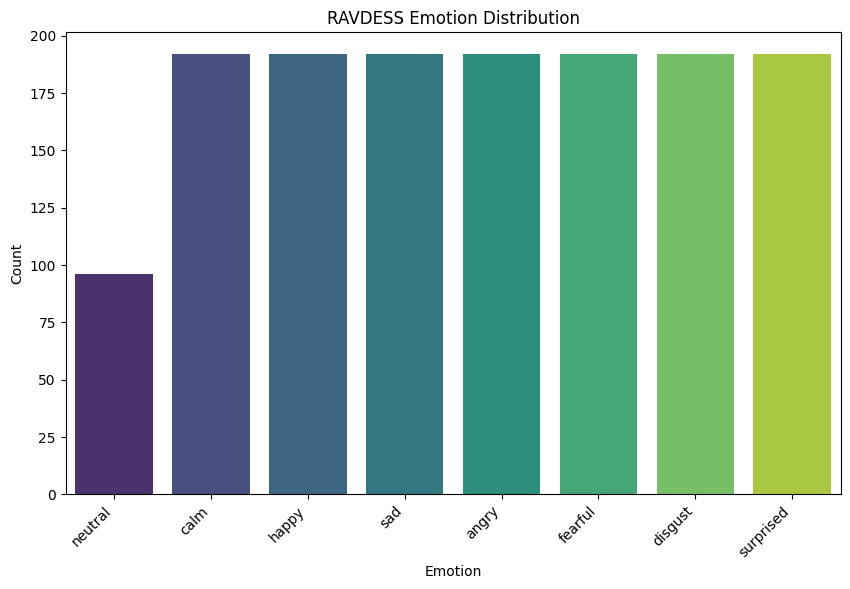

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ravdess = ravdess_data()  # Assuming ravdess_data() returns your DataFrame

plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df_ravdess, palette='viridis')
plt.title('RAVDESS Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

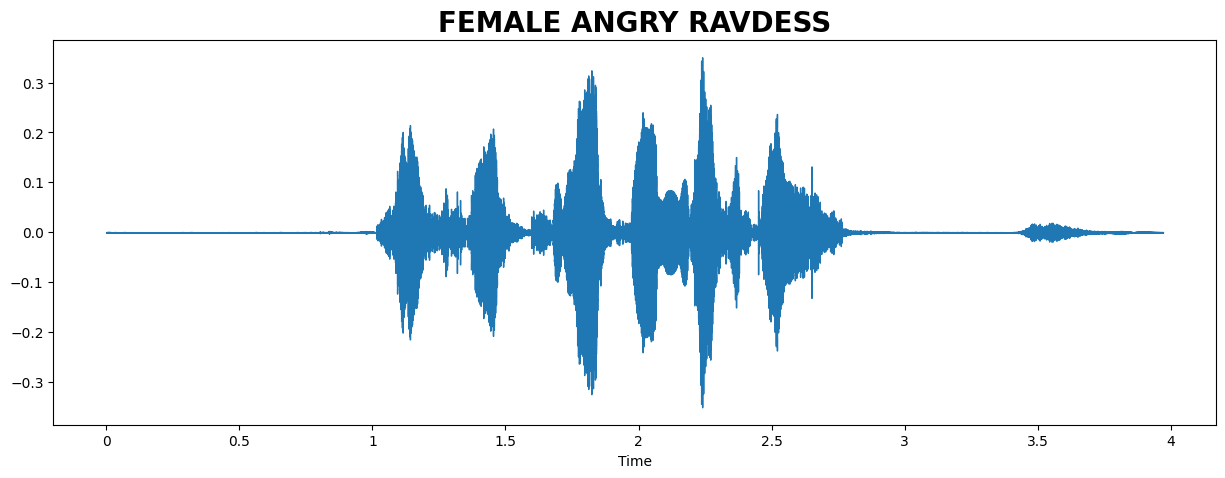

In [12]:
#female angry
import IPython.display as ipd

RAV = '/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/'
# a fearful track
fname = RAV + 'Actor_08/03-01-05-02-01-01-08.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("FEMALE ANGRY RAVDESS", fontweight='bold', fontsize=20)
# play the audio
ipd.Audio(fname)

In [13]:

def visualize_audio_features(fname):
  """
  Visualizes various audio features for a given audio file.

  Args:
    fname: Path to the audio file.
  """

  data, sampling_rate = librosa.load(fname)

  # Zero Crossing Rate
  zero_crossing_rate = librosa.feature.zero_crossing_rate(data)[0]
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(data, sr=sampling_rate, alpha=0.4)
  plt.plot(zero_crossing_rate, color='r')
  plt.title('Zero Crossing Rate')
  plt.show()


  # MFCCs
  mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')
  plt.colorbar()
  plt.title('MFCCs')
  plt.tight_layout()
  plt.show()


  # RMSE
  rmse = librosa.feature.rms(y=data)[0]
  plt.figure(figsize=(10, 4))
  plt.plot(rmse)
  plt.title('RMSE')
  plt.show()


  # Mel Spectrogram
  spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
  spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()


  # Spectral Rolloff
  spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sampling_rate)[0]
  plt.figure(figsize=(10, 4))
  plt.plot(spectral_rolloff)
  plt.title('Spectral Rolloff')
  plt.show()


  # Chroma STFT (You can adapt this to your specific use case)
  chroma_stft = librosa.feature.chroma_stft(y=data, sr=sampling_rate)
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
  plt.colorbar()
  plt.title('Chroma STFT')
  plt.tight_layout()
  plt.show()


## **FEMALE ANGRY FEATURES**

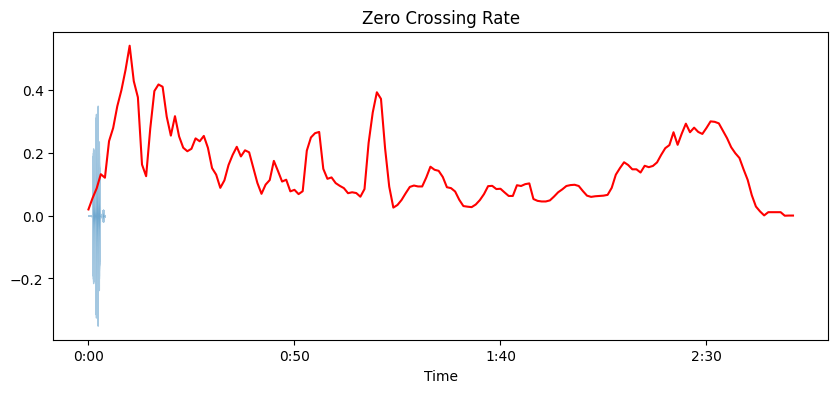

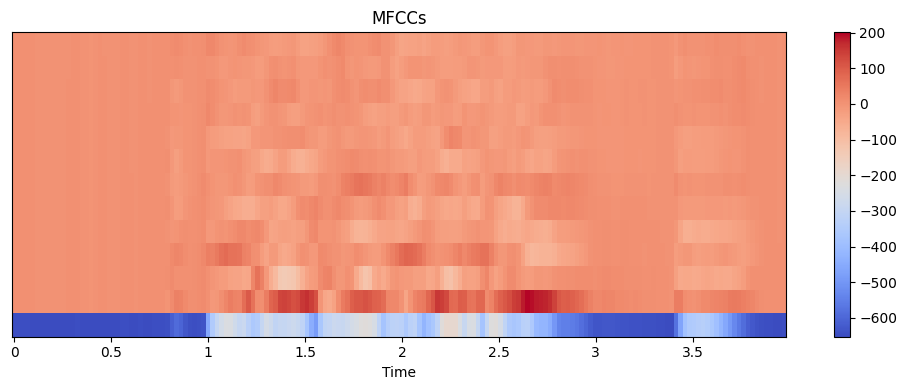

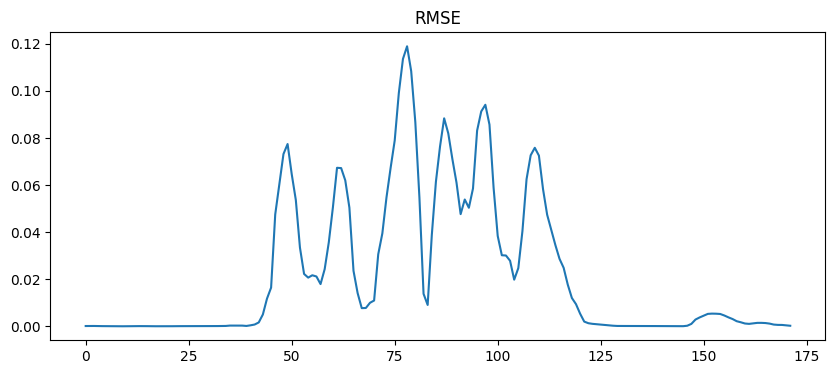

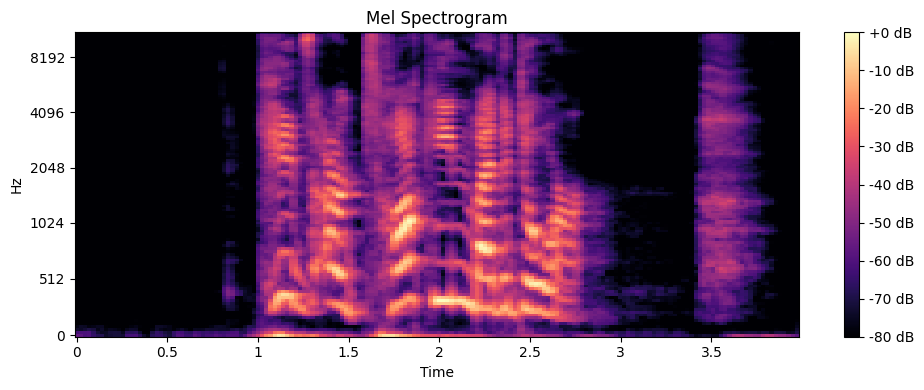

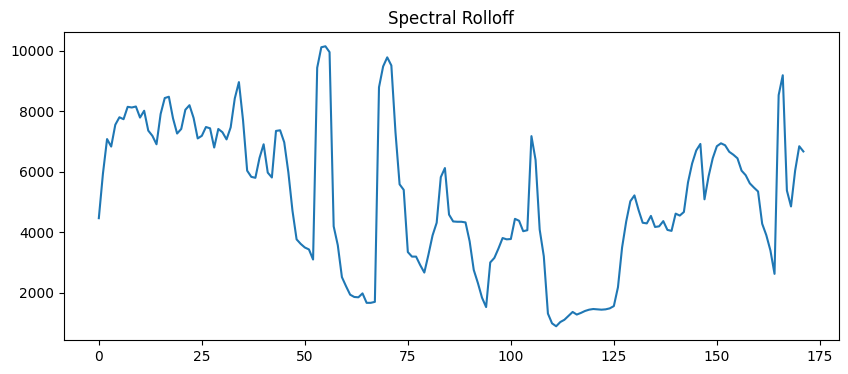

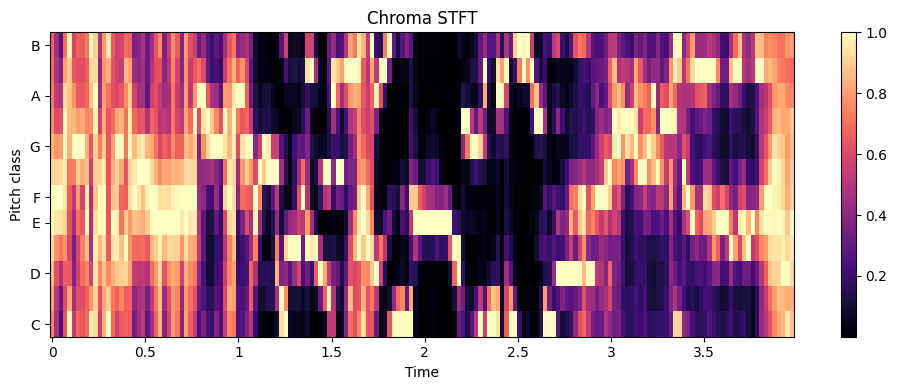

In [14]:
visualize_audio_features(fname)

## **MALE ANGRY FEATURES**

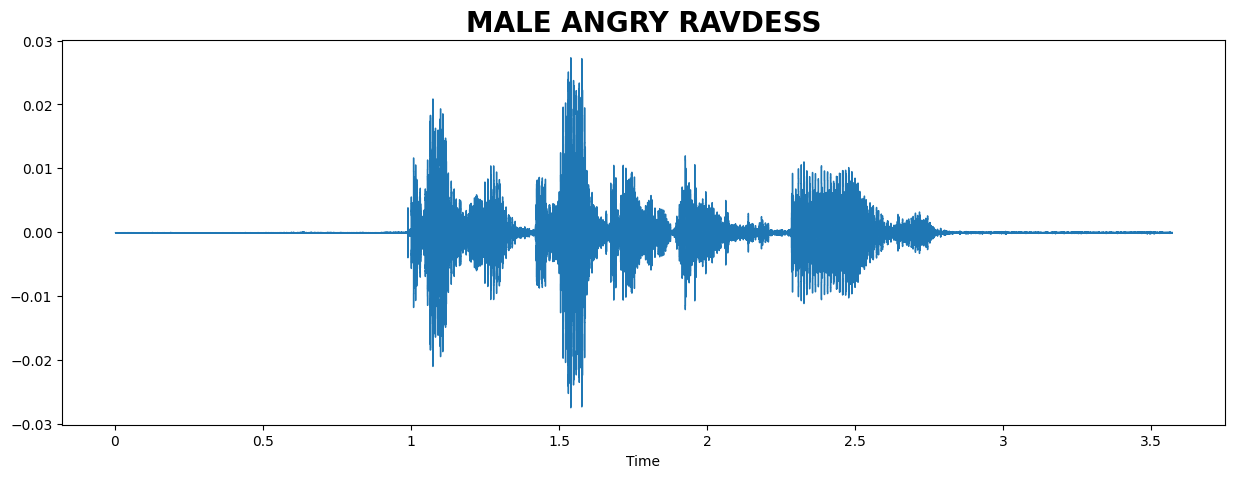

In [15]:
RAV = '/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/'

fname = RAV + 'Actor_09/03-01-05-01-01-01-09.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("MALE ANGRY RAVDESS", fontweight='bold', fontsize=20)
# play the audio
ipd.Audio(fname)


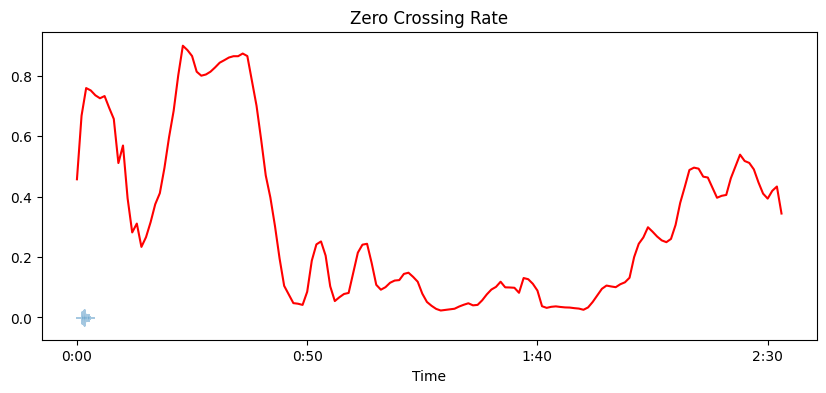

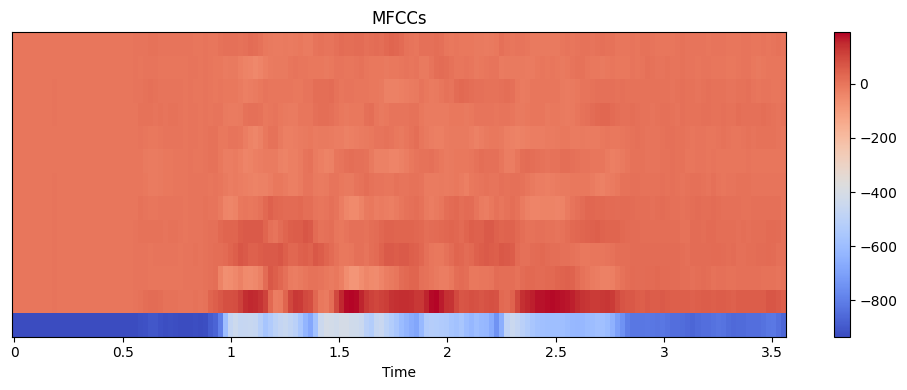

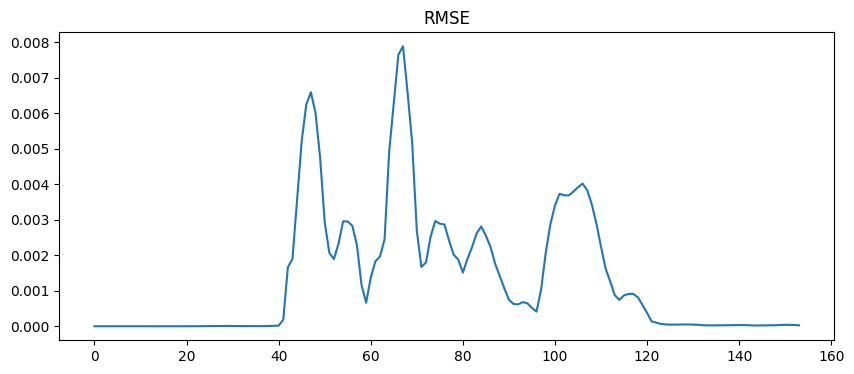

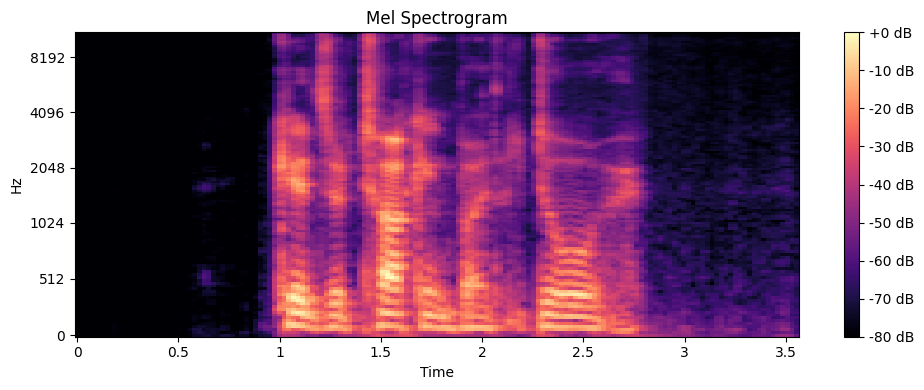

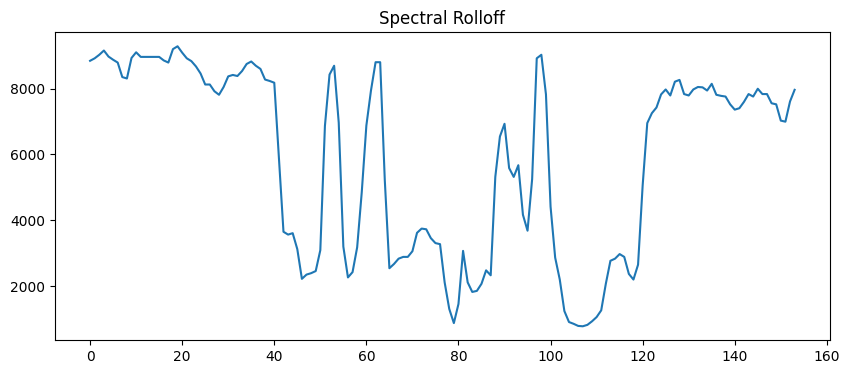

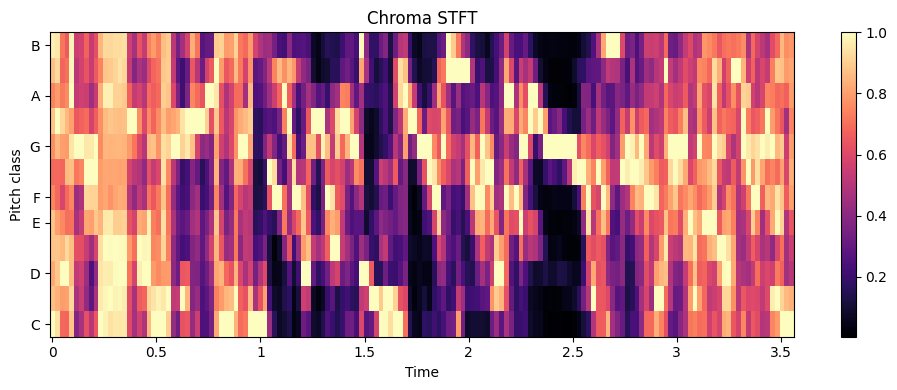

In [16]:
visualize_audio_features(fname)

## **HAPPY FEATURES**

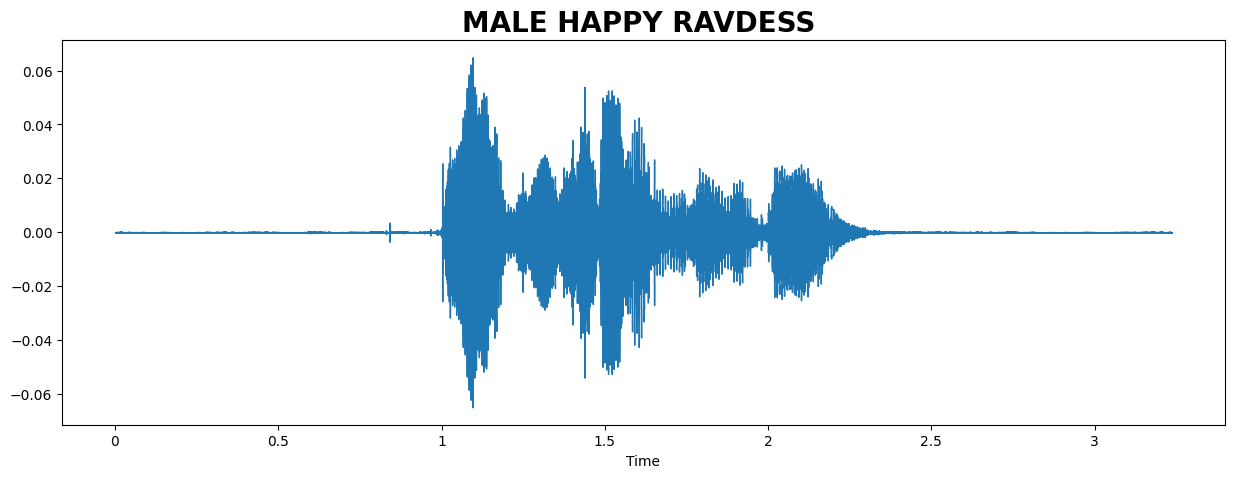

In [17]:
RAV = '/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/'
# Source - RAVDESS; Gender - Male; Emotion - Happy
fname = RAV + "Actor_11/03-01-03-01-02-02-11.wav"
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("MALE HAPPY RAVDESS ", fontweight='bold', fontsize=20)
# play the audio
ipd.Audio(fname)


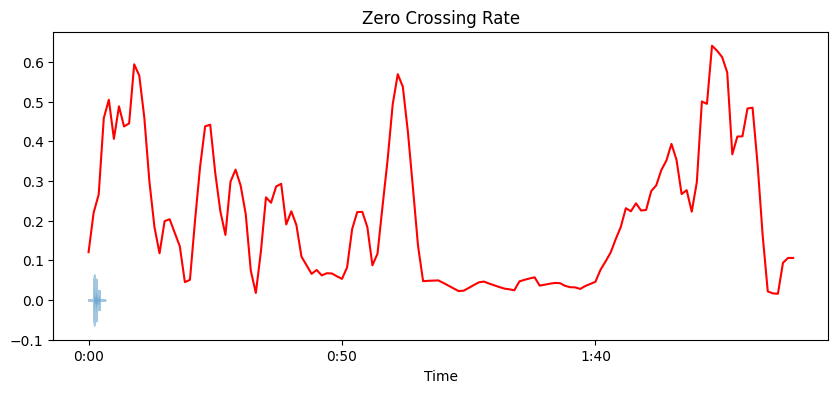

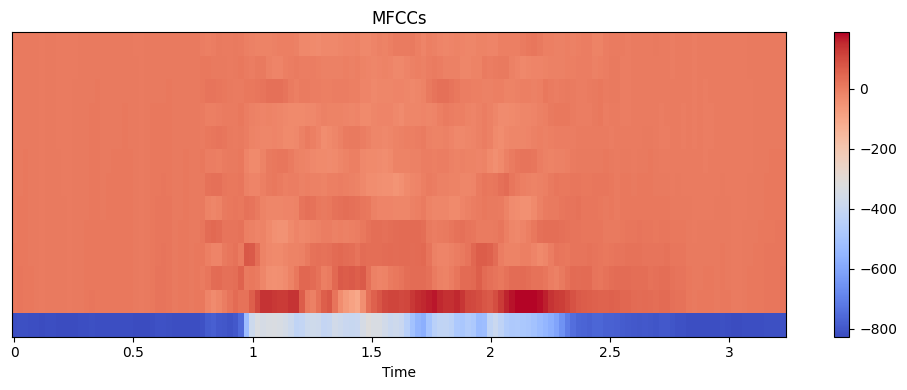

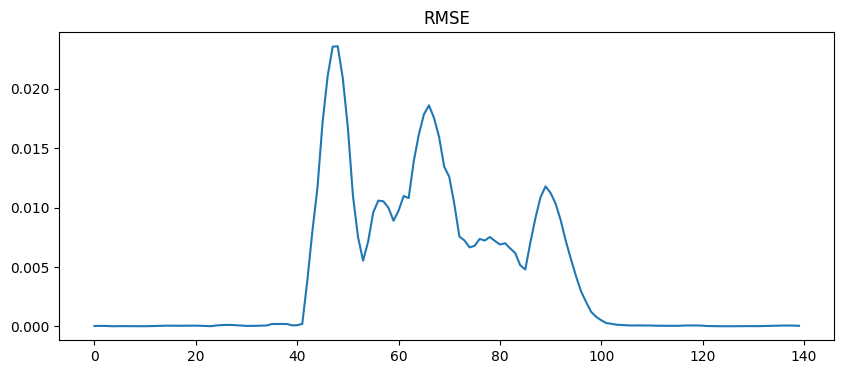

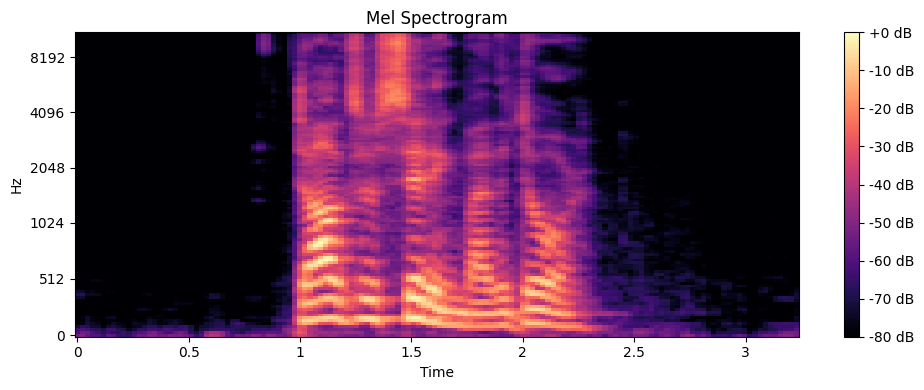

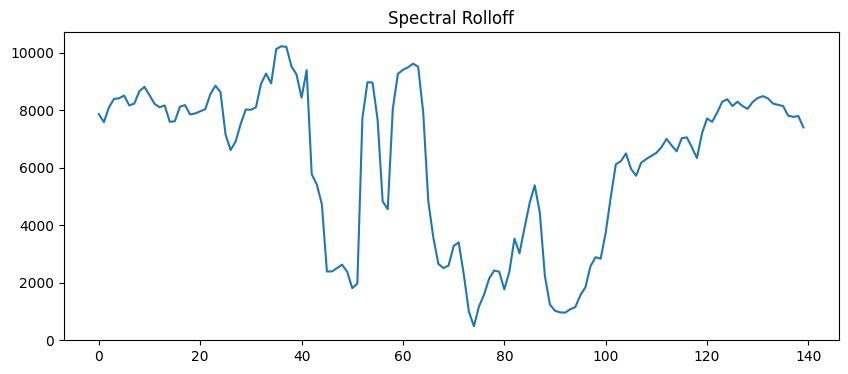

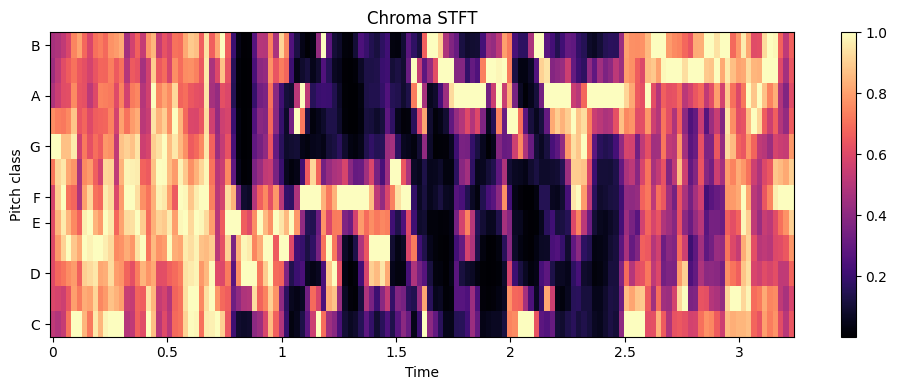

In [18]:
visualize_audio_features(fname)

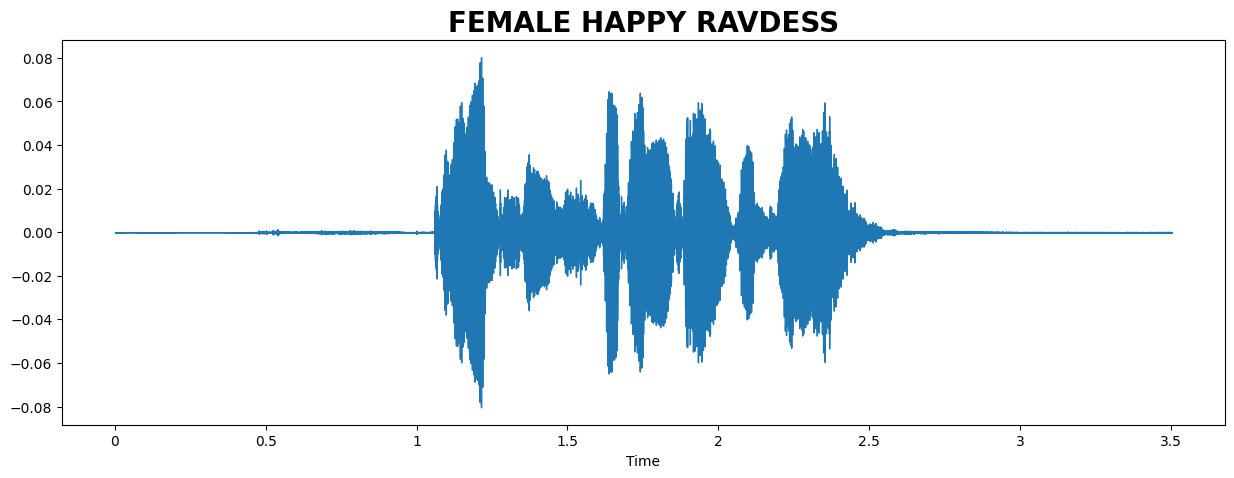

In [19]:
RAV = '/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/'
# Source - RAVDESS; Gender - Female; Emotion - Happy

fname = RAV + "Actor_12/03-01-03-01-02-01-12.wav"
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("FEMALE HAPPY RAVDESS", fontweight='bold', fontsize=20)
# play the audio
ipd.Audio(fname)


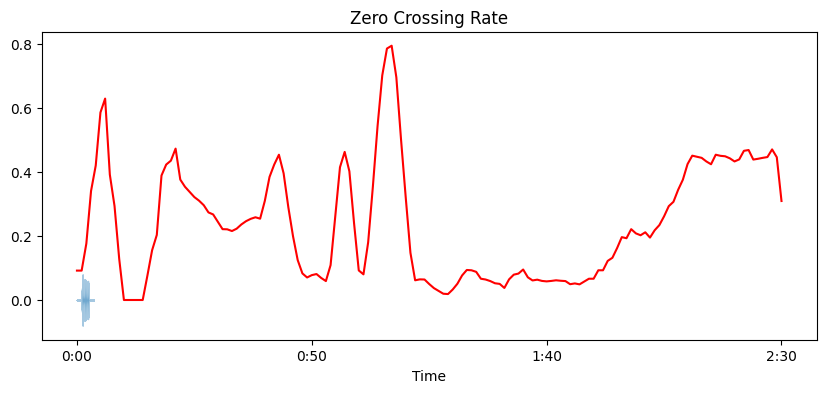

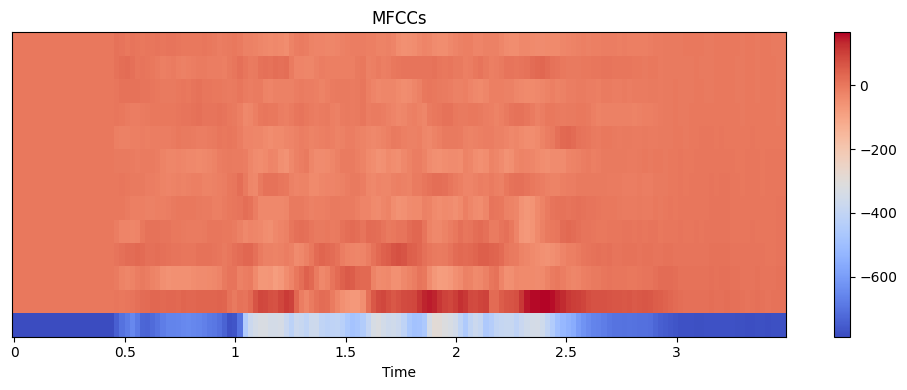

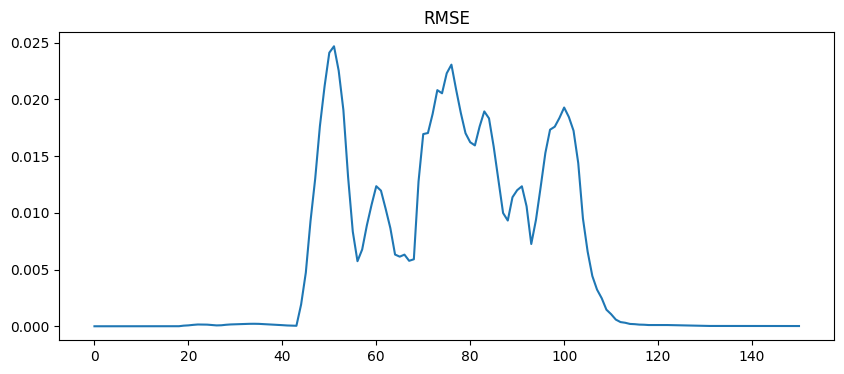

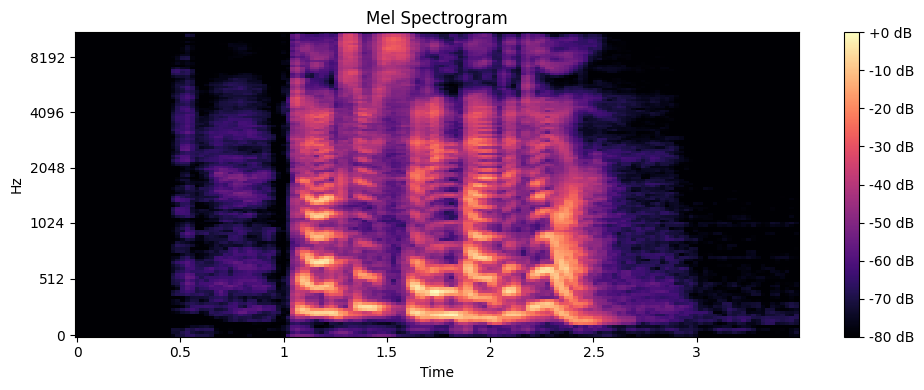

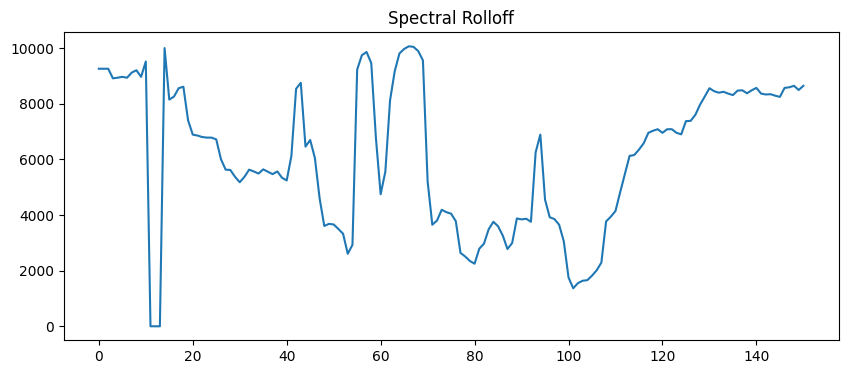

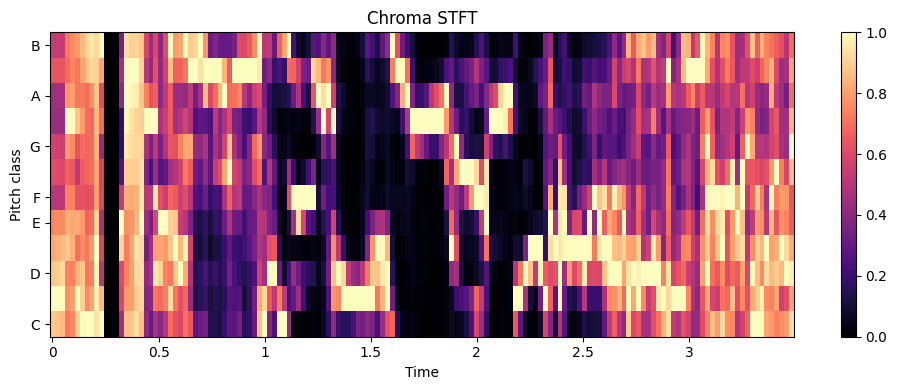

In [20]:
visualize_audio_features(fname)

In [21]:
 crema_data()


length of crema dataset 7442


AudioPath    Label
0     /content/drive/MyDrive/Audiofiles/AudioWAV/100...    angry
1     /content/drive/MyDrive/Audiofiles/AudioWAV/100...  disgust
2     /content/drive/MyDrive/Audiofiles/AudioWAV/100...     fear
3     /content/drive/MyDrive/Audiofiles/AudioWAV/100...    happy
4     /content/drive/MyDrive/Audiofiles/AudioWAV/100...  neutral
...                                                 ...      ...
7437  /content/drive/MyDrive/Audiofiles/AudioWAV/109...  disgust
7438  /content/drive/MyDrive/Audiofiles/AudioWAV/109...     fear
7439  /content/drive/MyDrive/Audiofiles/AudioWAV/109...    happy
7440  /content/drive/MyDrive/Audiofiles/AudioWAV/109...  neutral
7441  /content/drive/MyDrive/Audiofiles/AudioWAV/109...      sad

[7442 rows x 2 columns]

length of crema dataset 7442


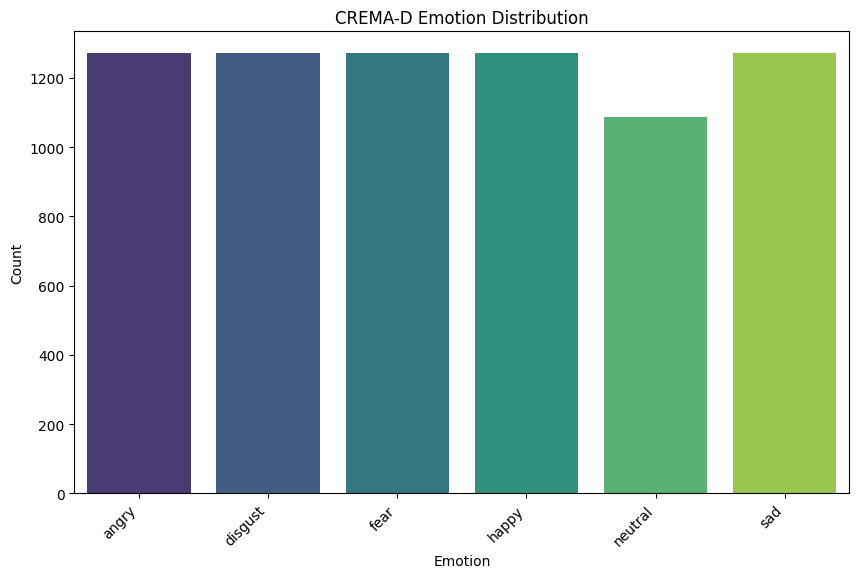

In [22]:
df_CREMAD =  crema_data()

plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df_CREMAD, palette='viridis')
plt.title('CREMA-D Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

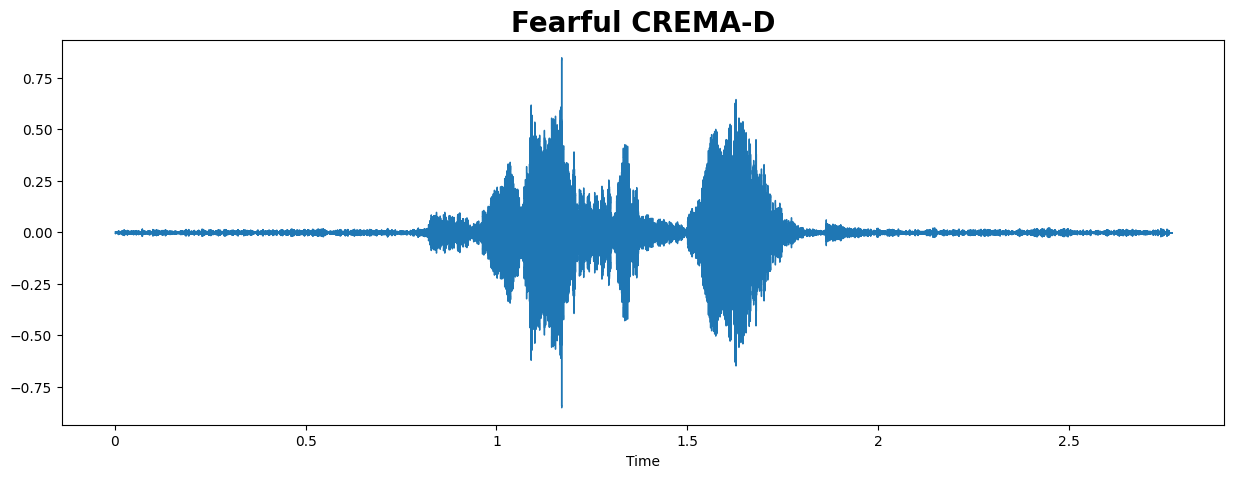

In [23]:
#fearful track
crema_data = "/content/drive/MyDrive/Audiofiles/AudioWAV/"
fname = crema_data + '1012_IEO_FEA_HI.wav'
data, sampling_rate = librosa.load(fname)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("Fearful CREMA-D", fontweight='bold', fontsize=20)
# Lets play the audio
ipd.Audio(fname)


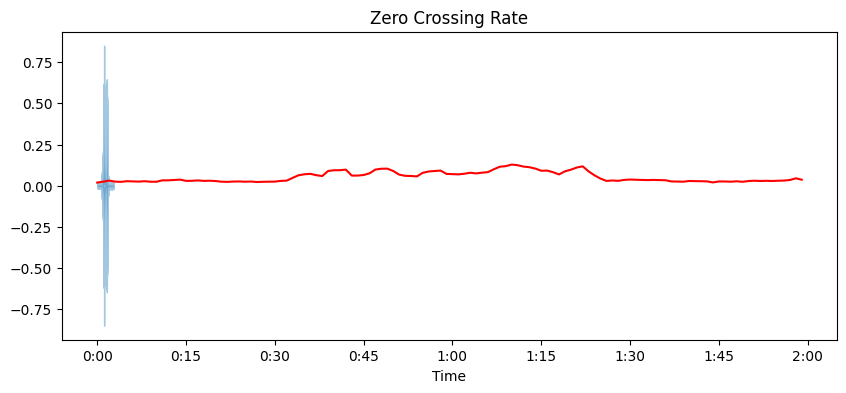

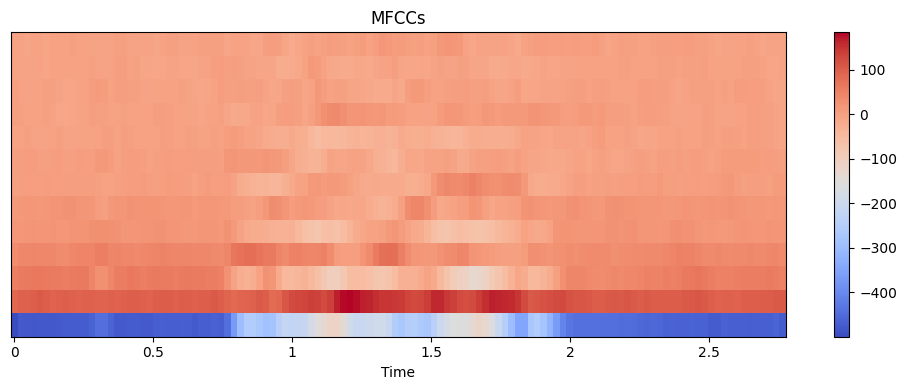

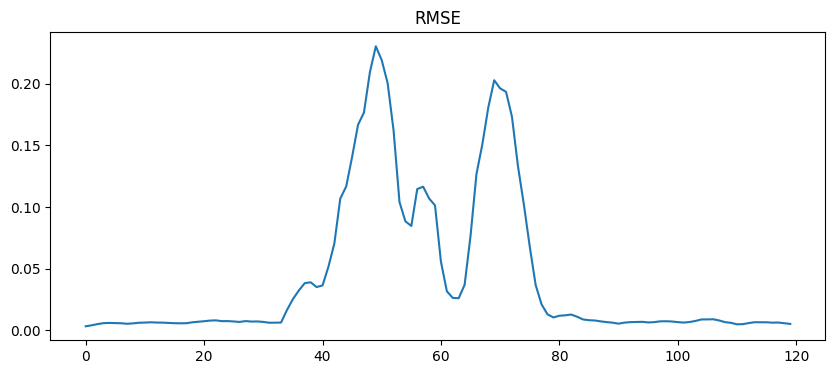

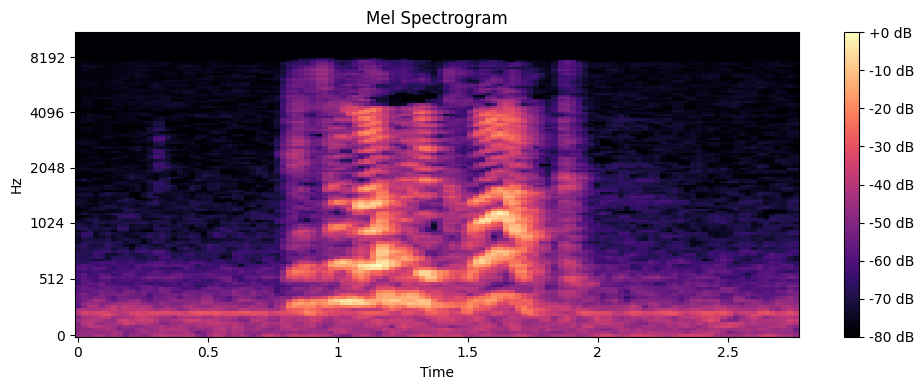

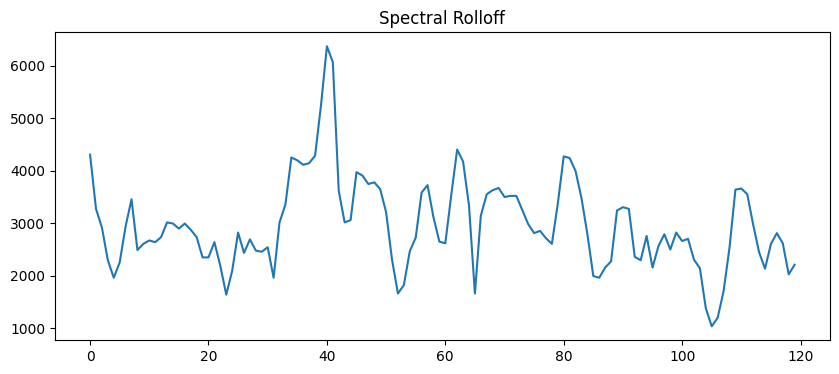

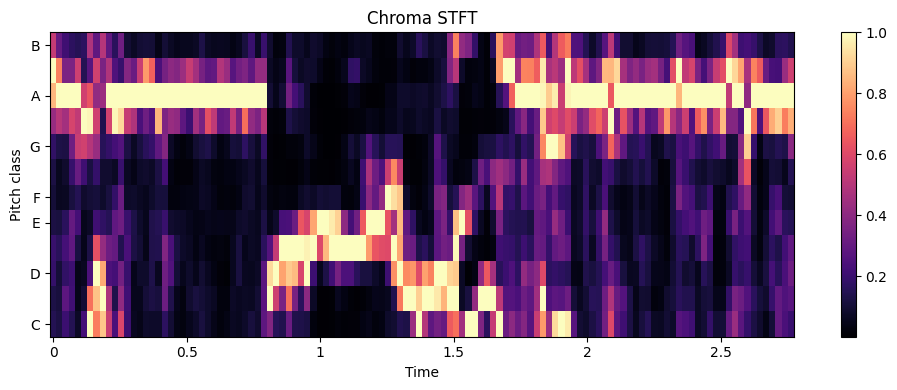

In [24]:
visualize_audio_features(fname)

In [25]:
tess_data()

length of tess dataset 2800


AudioPath  Label
0     /content/drive/MyDrive/Audiofiles/TESS Toronto...  angry
1     /content/drive/MyDrive/Audiofiles/TESS Toronto...  angry
2     /content/drive/MyDrive/Audiofiles/TESS Toronto...  angry
3     /content/drive/MyDrive/Audiofiles/TESS Toronto...  angry
4     /content/drive/MyDrive/Audiofiles/TESS Toronto...  angry
...                                                 ...    ...
2795  /content/drive/MyDrive/Audiofiles/TESS Toronto...    sad
2796  /content/drive/MyDrive/Audiofiles/TESS Toronto...    sad
2797  /content/drive/MyDrive/Audiofiles/TESS Toronto...    sad
2798  /content/drive/MyDrive/Audiofiles/TESS Toronto...    sad
2799  /content/drive/MyDrive/Audiofiles/TESS Toronto...    sad

[2800 rows x 2 columns]

length of tess dataset 2800


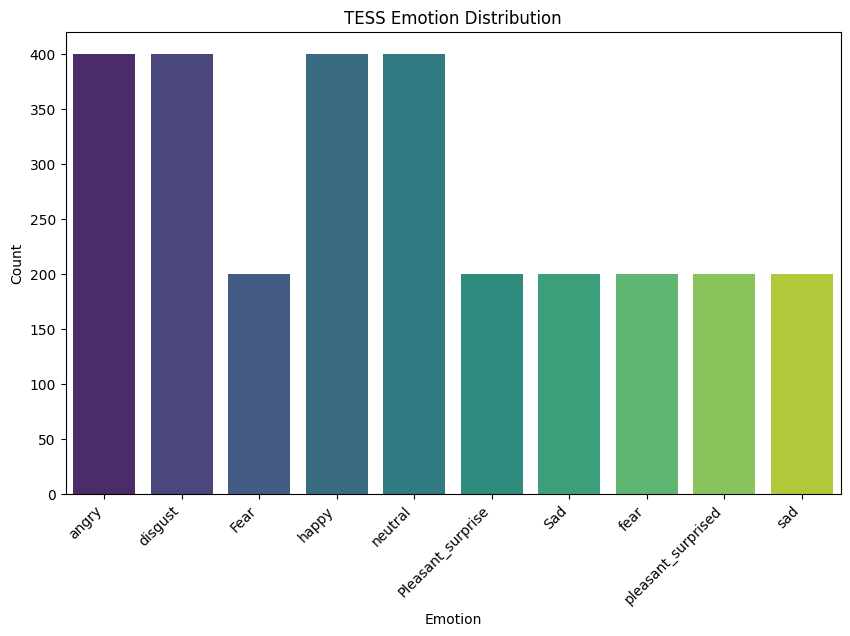

In [26]:

df_tess = tess_data()

plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df_tess, palette='viridis')
plt.title('TESS Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

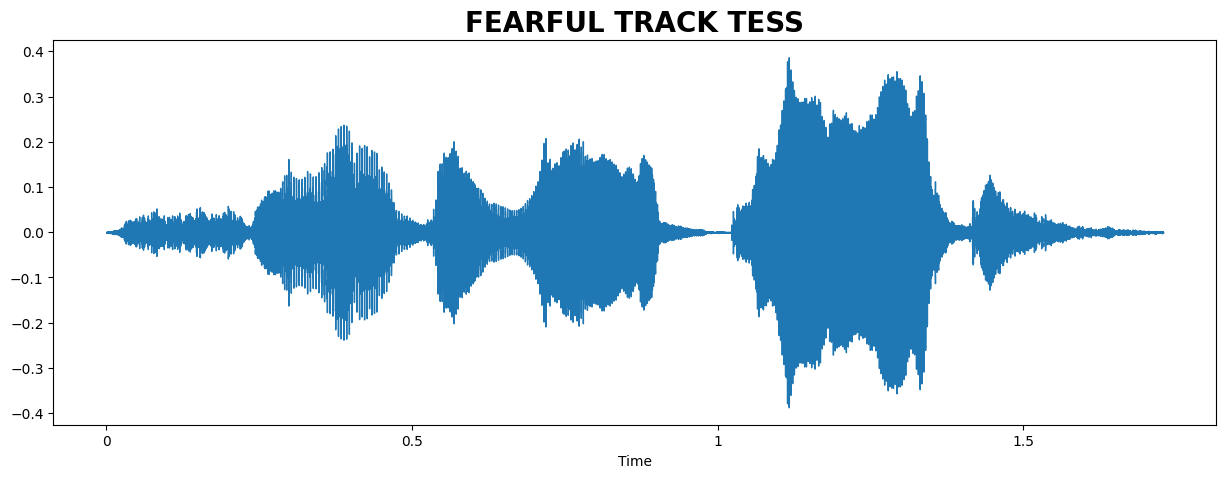

In [27]:
# lets play a fearful track
tess = "/content/drive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
fname = tess + 'YAF_fear/YAF_dog_fear.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("FEARFUL TRACK TESS", fontweight='bold', fontsize=20)
# Lets play the audio
ipd.Audio(fname)



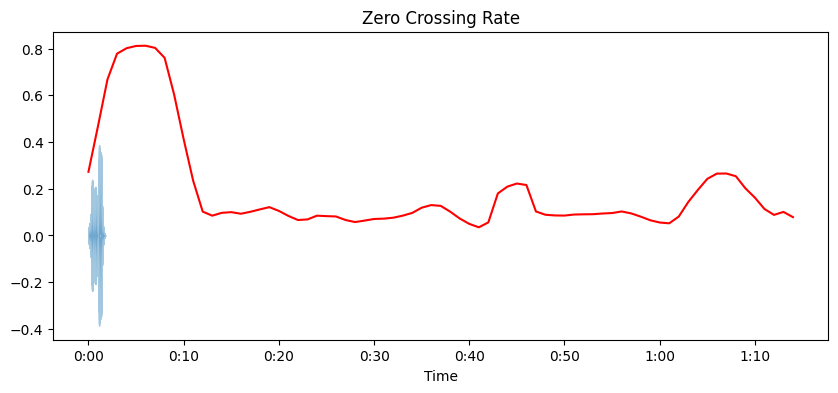

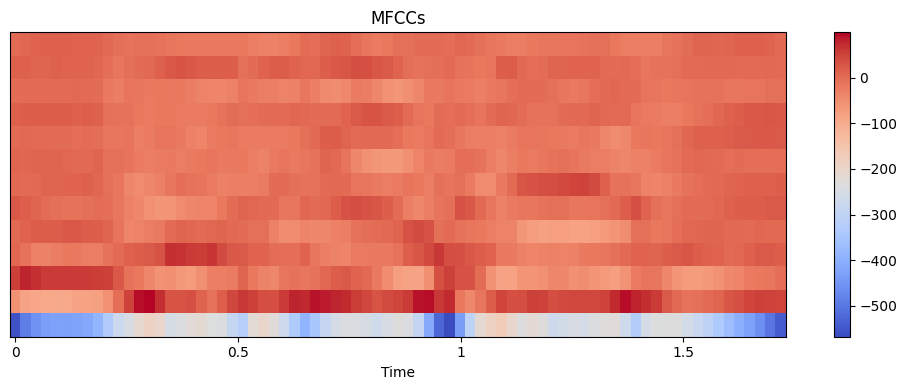

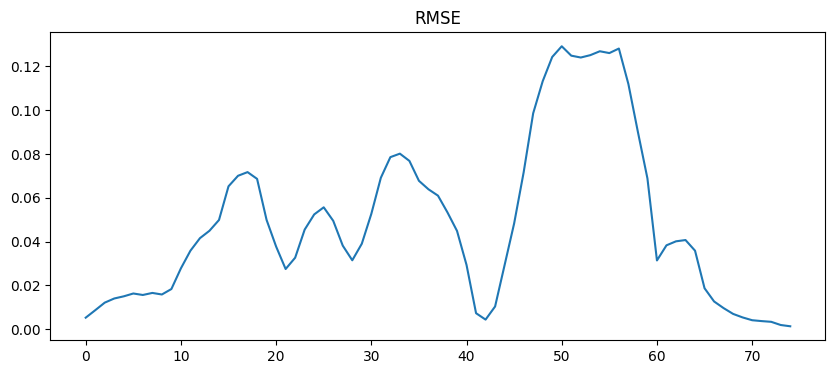

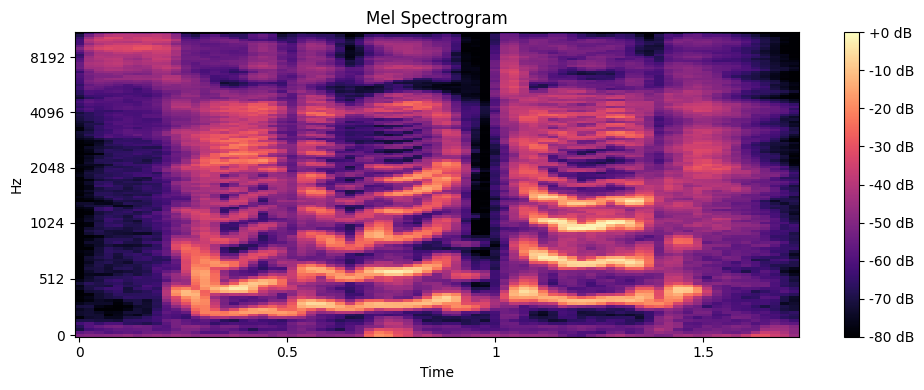

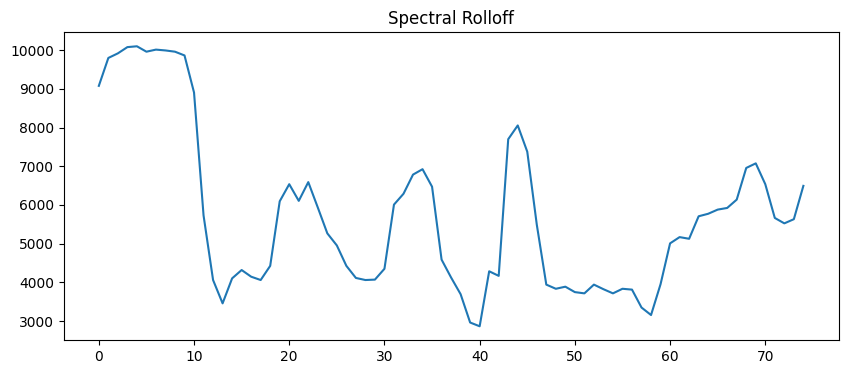

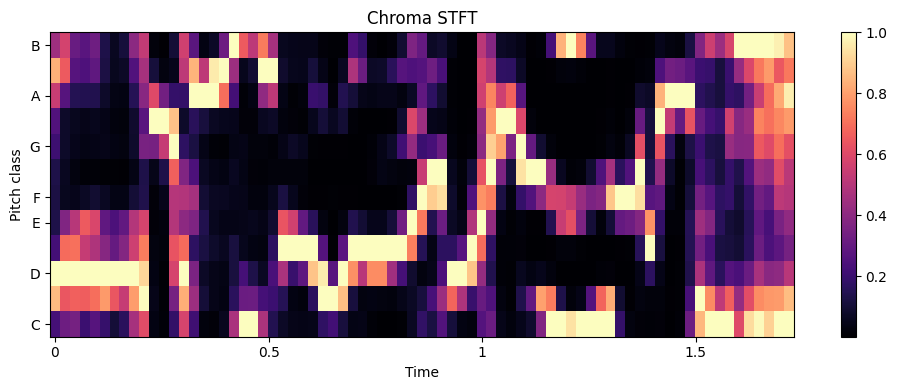

In [28]:
visualize_audio_features(fname)

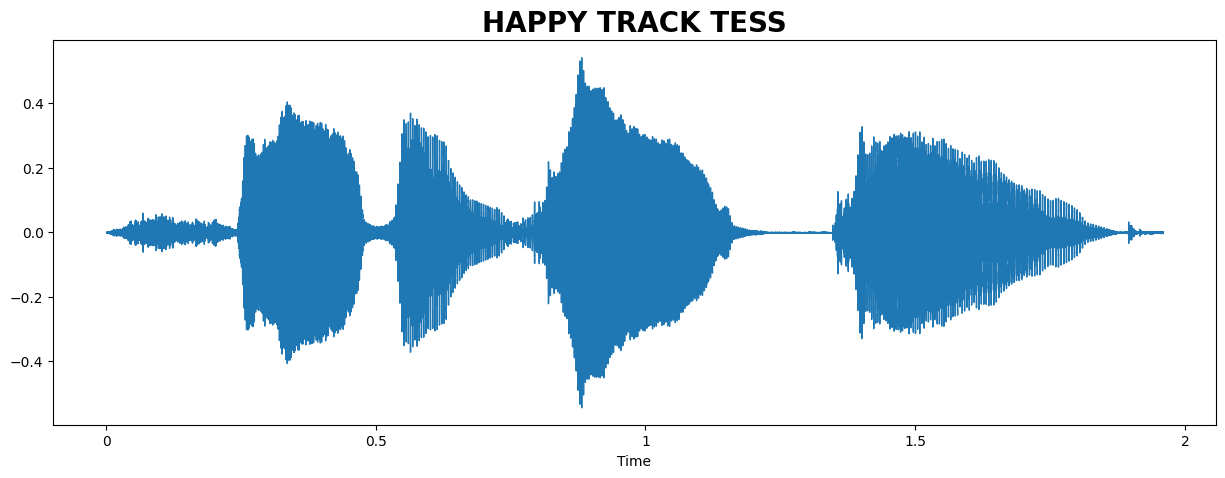

In [29]:
# lets play a happy track
tess = "/content/drive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
fname = tess + 'YAF_happy/YAF_dog_happy.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("HAPPY TRACK TESS", fontweight='bold', fontsize=20)
# Lets play the audio
ipd.Audio(fname)

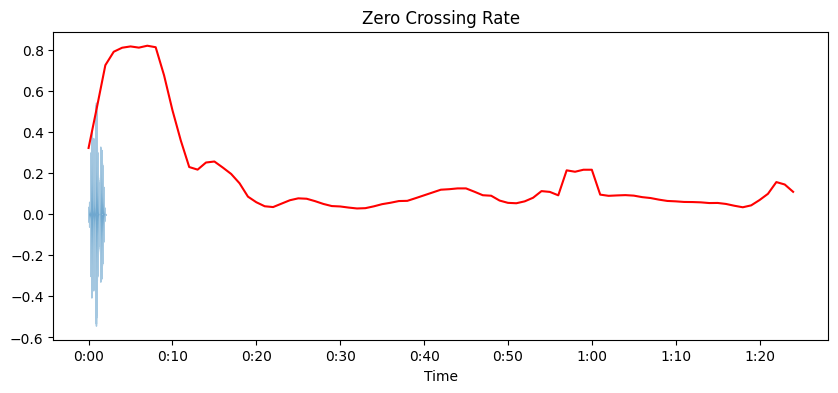

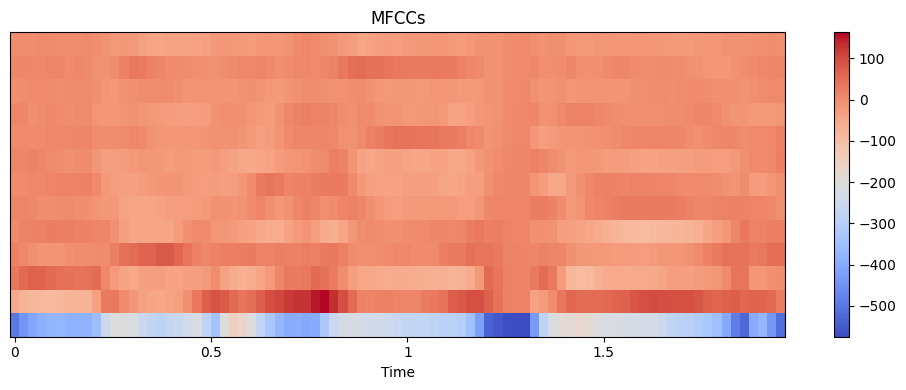

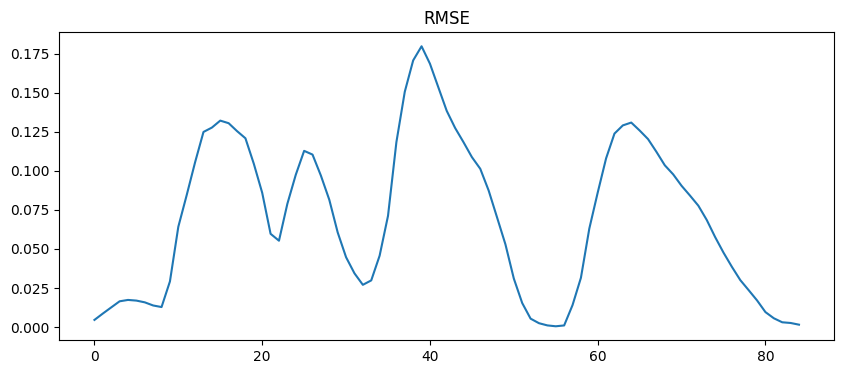

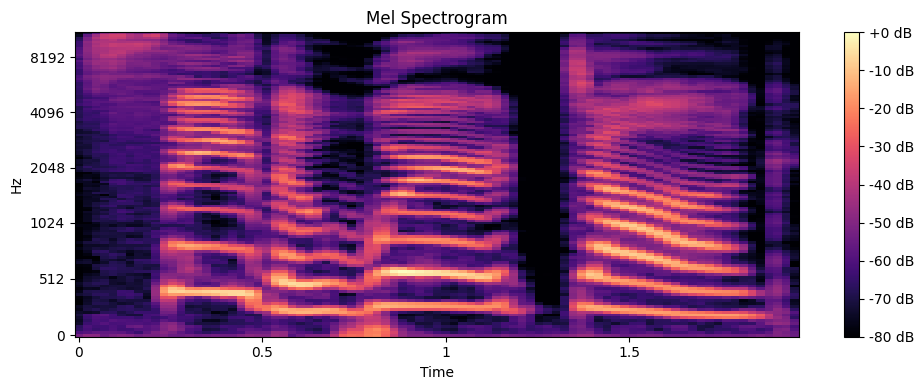

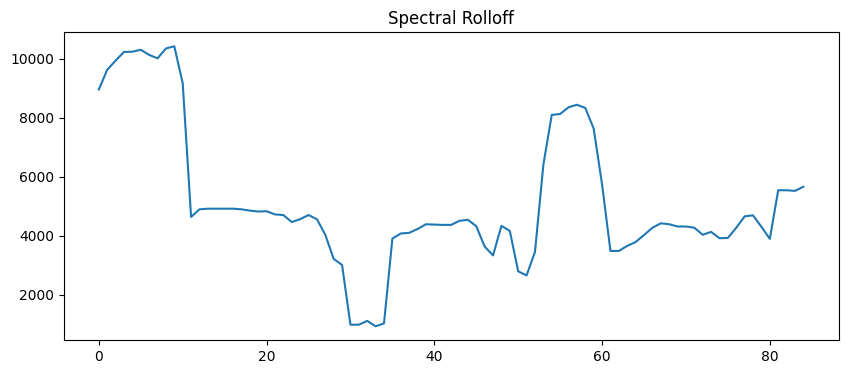

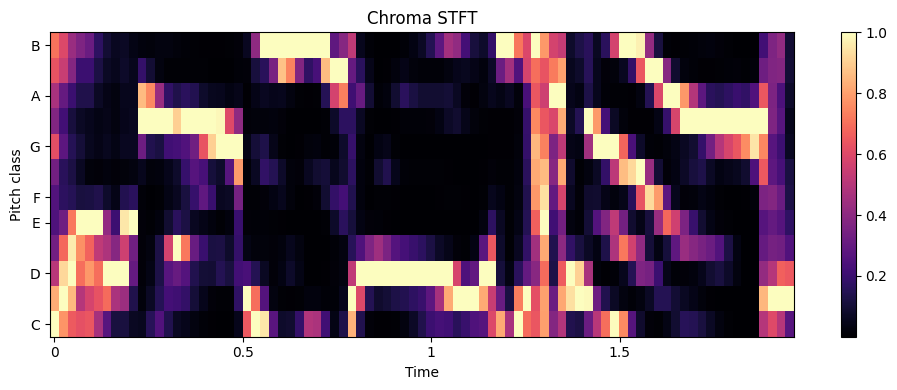

In [30]:
visualize_audio_features(fname)

In [31]:
saveee_data()

length of savee dataset 480


AudioPath     Label
0     /content/drive/MyDrive/Audiofiles/ALL/DC_a01.wav     anger
1     /content/drive/MyDrive/Audiofiles/ALL/DC_a02.wav     anger
2     /content/drive/MyDrive/Audiofiles/ALL/DC_a03.wav     anger
3     /content/drive/MyDrive/Audiofiles/ALL/DC_a04.wav     anger
4     /content/drive/MyDrive/Audiofiles/ALL/DC_a05.wav     anger
..                                                 ...       ...
475  /content/drive/MyDrive/Audiofiles/ALL/KL_su11.wav  surprise
476  /content/drive/MyDrive/Audiofiles/ALL/KL_su12.wav  surprise
477  /content/drive/MyDrive/Audiofiles/ALL/KL_su13.wav  surprise
478  /content/drive/MyDrive/Audiofiles/ALL/KL_su14.wav  surprise
479  /content/drive/MyDrive/Audiofiles/ALL/KL_su15.wav  surprise

[480 rows x 2 columns]

length of savee dataset 480


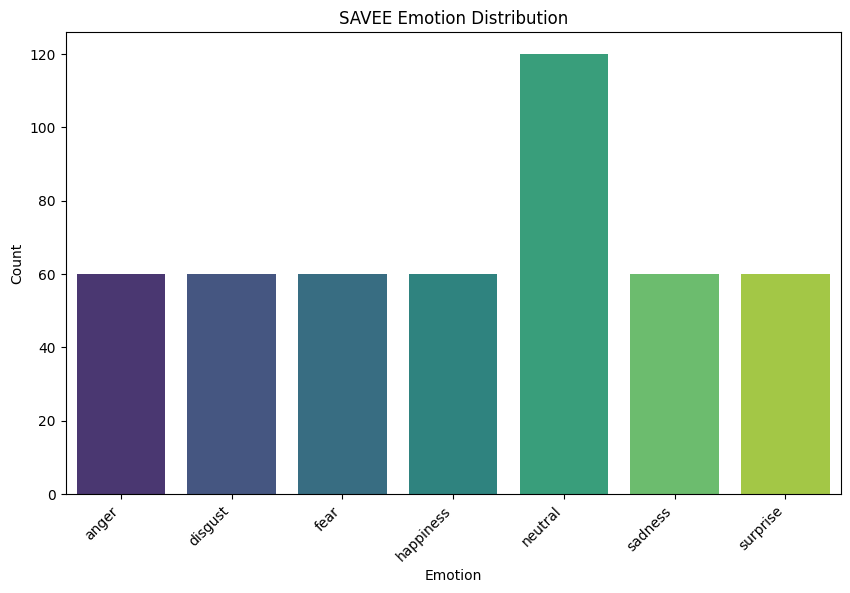

In [32]:


df_savee = saveee_data()

plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df_savee, palette='viridis')
plt.title('SAVEE Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

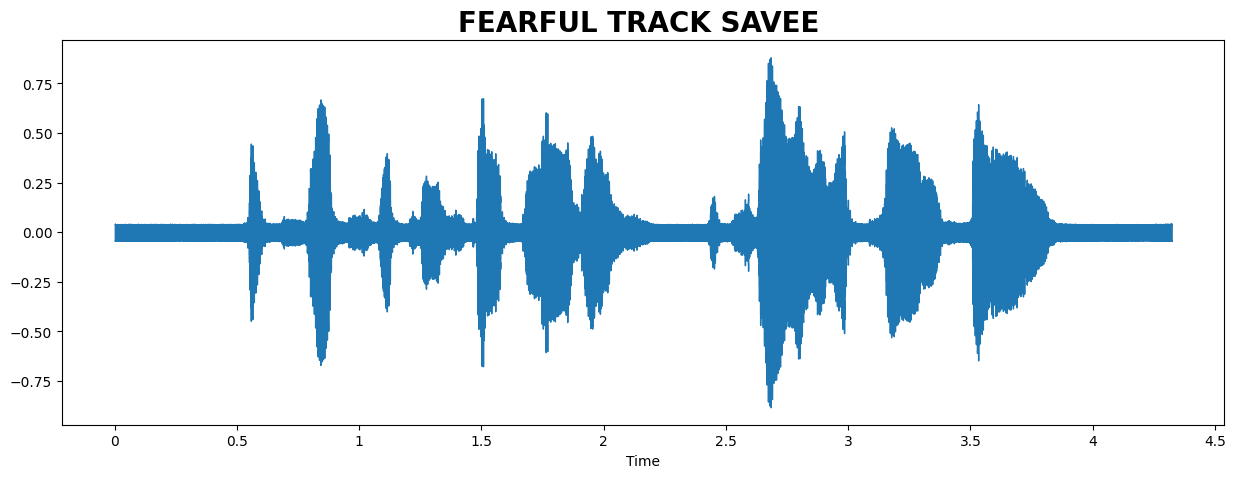

In [33]:
#  FEARFUL TRACK SAVEE
SAVEE = "/content/drive/MyDrive/Audiofiles/ALL/"  # Replace with your actual path

fname = SAVEE + 'DC_f11.wav'
data, sampling_rate = librosa.load(fname)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("FEARFUL TRACK SAVEE ", fontweight='bold', fontsize=20)
# Display the audio using IPython.display.Audio
ipd.Audio(fname)

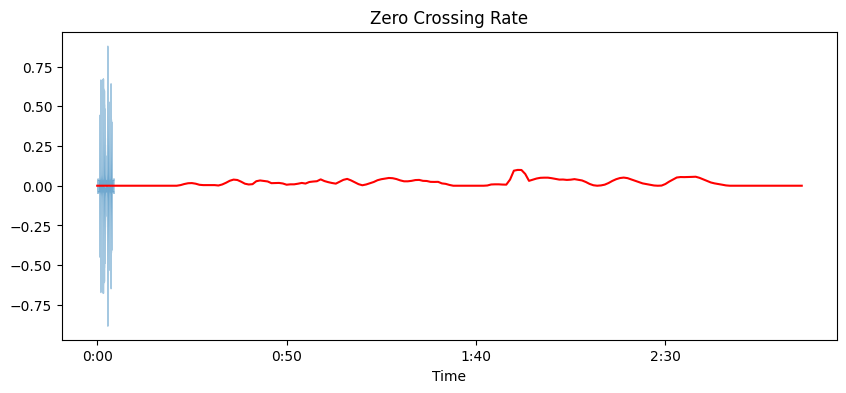

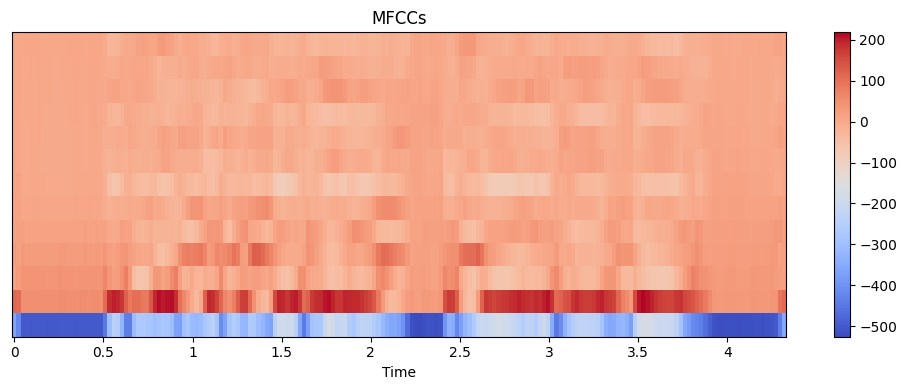

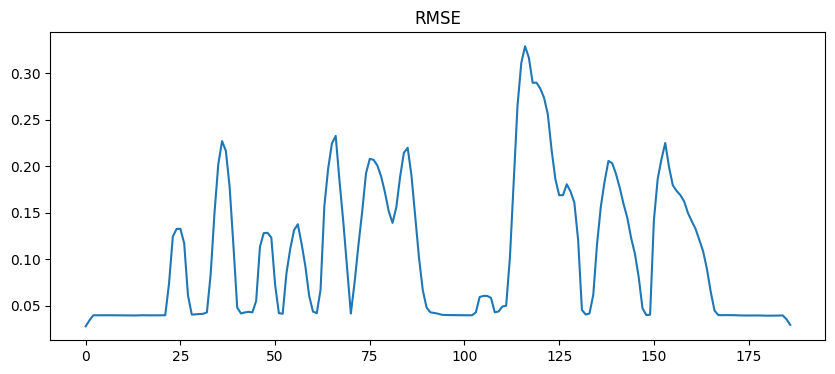

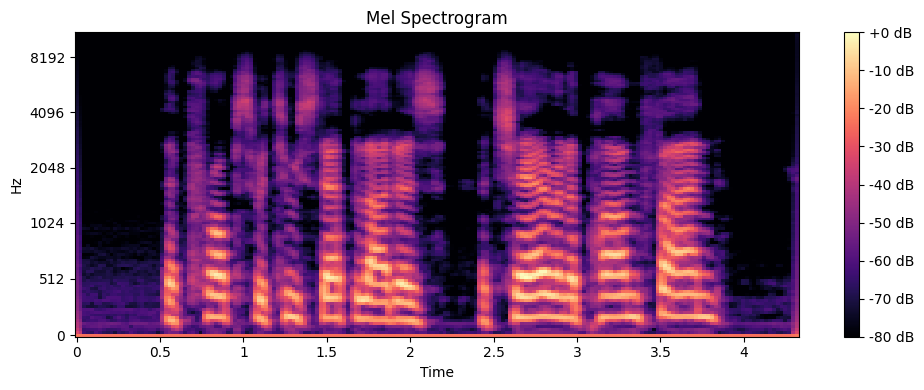

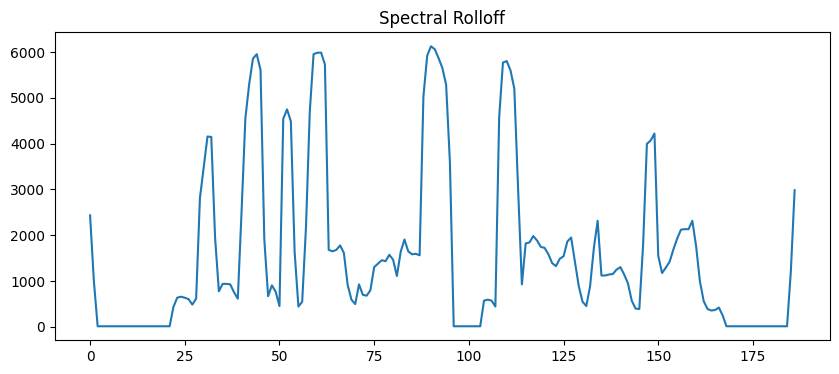

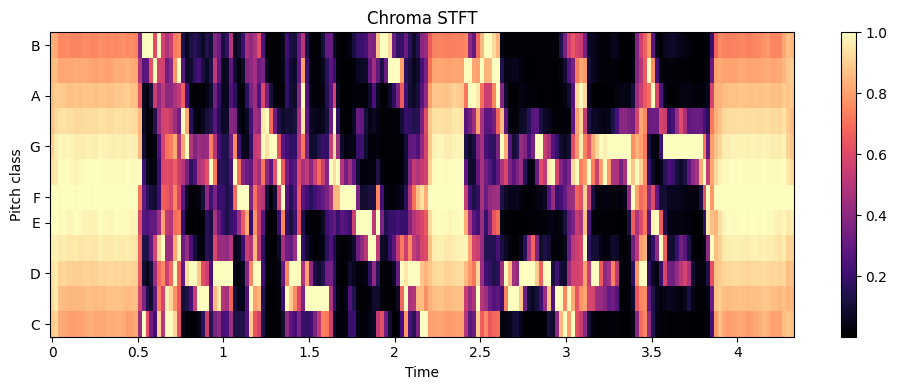

In [34]:
visualize_audio_features(fname)

In [35]:

# WHOLE CODE


import pandas as pd
import numpy as np
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
from google.colab import drive
!pip install ffmpeg-python
warnings.filterwarnings("ignore")
drive.mount('/content/drive')
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

#function for getting ravdess dataset details and labeling
def ravdess_data():
  #directory of the audio dataset
  ravdess = "/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "/content/drive/MyDrive/Audiofiles/AudioWAV/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema

#function for getting tess dataset and labeling
def tess_data():
  #directory of the audio dataset
  tess = "/content/drive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
  tess_emotion = []
  tess_path = []
  tess_folder = os.listdir(tess)
  for i in tess_folder:
    emotion = i.split('_',1)[1]
    inner_files = os.listdir(tess+i+'/')
    for j in inner_files:
      tess_path.append(tess+i+'/'+j)
      tess_emotion.append(emotion)

  #convert to dataframe
  df_tess = pd.DataFrame([tess_path,tess_emotion]).T
  df_tess.columns = ["AudioPath","Label"]
  print("length of tess dataset",len(df_tess))

  return df_tess

#function to get savee dataset and labeling
def saveee_data():
  #directory of the audio dataset
  savee = "/content/drive/MyDrive/Audiofiles/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    try:
      emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    except:
      print(i)
      continue

    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)

  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee

@calc_time
def fetch_data():
  #get ravdess data
  df_ravdess = ravdess_data()
  #get crema data
  df_crema = crema_data()
  #get tess data
  df_tess = tess_data()
  #get savee data
  df_savee = saveee_data()
  #combine all four dataset into one single dataset and create a dataframe
  frames = [df_ravdess,df_crema,df_tess,df_savee]
  final_combined = pd.concat(frames)
  final_combined.reset_index(drop=True,inplace=True)
  #save the information of datasets with their path and labels into a csv file
  final_combined.to_csv("/content/drive/MyDrive/preprocesseddata.csv",index=False,header=True)
  print("Total length of the dataset is {}".format(len(final_combined)))
  return final_combined

#below are four data agumentation functions for noise, stretch, shift, pitch
#function to add noise to audio
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

# #fuction to strech audio
# def stretch(data, rate=0.8):
#   return librosa.effects.time_stretch(data, rate)


#fuction to strech audio
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate=rate) # Pass rate as a keyword argument

#fucntion to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

#function to change pitch
# def pitch(data, sampling_rate, pitch_factor=0.7):
#   return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#fucntion to change pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor) # Pass sr and n_steps as keyword arguments

#fuction to extract audio features from the audio files given the information of their path
#path and label information comes from fetch_data fucntion
#also file preprocesseddata.csv stores the information of paths of audio files their label information
#the print statements are commented these statements were used to see the number of features returned as output
def extract_features(data,sample_rate):

  #zero crossing rate
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result, zcr))
  #print('zcr',result.shape)

  #chroma shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  #print('chroma',result.shape)

  #mfcc
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  #print('mfcc',result.shape)

  #rmse
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))
  #print('rmse',result.shape)

  #melspectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  #print('mel',result.shape)

  #rollof
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, rollof))
  #print('rollof',result.shape)

  #centroids
  centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, centroid))
  #print('centroids',result.shape)

  #contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
  #print('contrast',result.shape)

  #bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, bandwidth))
  #print('bandwidth',result.shape)

  #tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, tonnetz))
  #print('tonnetz',result.shape)

  return result

#function is used to get all augmented plus original features for given audio file
def get_features(path):
  #set the duration and offset
  #librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

  #get audio features without augmentation
  res1 = extract_features(data,sample_rate)
  result = np.array(res1)

  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sample_rate)
  result = np.vstack((result, res2))

  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch,sample_rate)
  result = np.vstack((result, res3))

  return result
#fucntion one by one takes aduio files from the path extracts features
#extracted audio features along with their label information are stored in a csv file
@calc_time
def Audio_features_extract():
  #this function is used to fetch the data from all the four datasets
  df = fetch_data()
  #count is used to keep a check of number of files processed
  count = 0
  #list to store audio features and their label information
  X_data, Y_label = [], []
  #zip audio path and label information and then iterate over them
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("Number of files processed ",count)
    #get the features
    #for one audio file it get three sets of features
    #original features, features with noise(agumentation) and feature with change in stretch and pitch
    #so one audio file generates three output and the label is same for all the outputs
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)
    count+=1
  #create a dataframe of aduio features
  Features = pd.DataFrame(X_data)
  #add label information
  Features['Label'] = Y_label
  #store the extracted features in a csv file

  Features.to_csv('/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv',index=False)

#this is just one time process so call this function once only to get the features
#once the features are extracted then these features are used for making model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
fetch_data()

length of ravdess dataset 1440
length of crema dataset 7442
length of tess dataset 2800
length of savee dataset 480
Total length of the dataset is 12162
Total time required: 1619.259 ms


AudioPath     Label
0      /content/drive/MyDrive/Audiofiles/audio_speech...   neutral
1      /content/drive/MyDrive/Audiofiles/audio_speech...   neutral
2      /content/drive/MyDrive/Audiofiles/audio_speech...   neutral
3      /content/drive/MyDrive/Audiofiles/audio_speech...   neutral
4      /content/drive/MyDrive/Audiofiles/audio_speech...      calm
...                                                  ...       ...
12157  /content/drive/MyDrive/Audiofiles/ALL/KL_su11.wav  surprise
12158  /content/drive/MyDrive/Audiofiles/ALL/KL_su12.wav  surprise
12159  /content/drive/MyDrive/Audiofiles/ALL/KL_su13.wav  surprise
12160  /content/drive/MyDrive/Audiofiles/ALL/KL_su14.wav  surprise
12161  /content/drive/MyDrive/Audiofiles/ALL/KL_su15.wav  surprise

[12162 rows x 2 columns]

In [ ]:

# WHOLE CODE


import pandas as pd
import numpy as np
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
from google.colab import drive
!pip install ffmpeg-python
warnings.filterwarnings("ignore")
drive.mount('/content/drive')
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

#function for getting ravdess dataset details and labeling
def ravdess_data():
  #directory of the audio dataset
  ravdess = "/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "/content/drive/MyDrive/Audiofiles/AudioWAV/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema

#function for getting tess dataset and labeling
def tess_data():
  #directory of the audio dataset
  tess = "/content/drive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
  tess_emotion = []
  tess_path = []
  tess_folder = os.listdir(tess)
  for i in tess_folder:
    emotion = i.split('_',1)[1]
    inner_files = os.listdir(tess+i+'/')
    for j in inner_files:
      tess_path.append(tess+i+'/'+j)
      tess_emotion.append(emotion)

  #convert to dataframe
  df_tess = pd.DataFrame([tess_path,tess_emotion]).T
  df_tess.columns = ["AudioPath","Label"]
  print("length of tess dataset",len(df_tess))

  return df_tess

#function to get savee dataset and labeling
def saveee_data():
  #directory of the audio dataset
  savee = "/content/drive/MyDrive/Audiofiles/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    try:
      emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    except:
      print(i)
      continue

    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)

  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee

@calc_time
def fetch_data():
  #get ravdess data
  df_ravdess = ravdess_data()
  #get crema data
  df_crema = crema_data()
  #get tess data
  df_tess = tess_data()
  #get savee data
  df_savee = saveee_data()
  #combine all four dataset into one single dataset and create a dataframe
  frames = [df_ravdess,df_crema,df_tess,df_savee]
  final_combined = pd.concat(frames)
  final_combined.reset_index(drop=True,inplace=True)
  #save the information of datasets with their path and labels into a csv file
  final_combined.to_csv("/content/drive/MyDrive/preprocesseddata.csv",index=False,header=True)
  print("Total length of the dataset is {}".format(len(final_combined)))
  return final_combined

#below are four data agumentation functions for noise, stretch, shift, pitch
#function to add noise to audio
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

# #fuction to strech audio
# def stretch(data, rate=0.8):
#   return librosa.effects.time_stretch(data, rate)


#fuction to strech audio
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate=rate) # Pass rate as a keyword argument

#fucntion to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

#function to change pitch
# def pitch(data, sampling_rate, pitch_factor=0.7):
#   return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#fucntion to change pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor) # Pass sr and n_steps as keyword arguments

#fuction to extract audio features from the audio files given the information of their path
#path and label information comes from fetch_data fucntion
#also file preprocesseddata.csv stores the information of paths of audio files their label information
#the print statements are commented these statements were used to see the number of features returned as output
def extract_features(data,sample_rate):

  #zero crossing rate
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result, zcr))
  #print('zcr',result.shape)

  #chroma shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  #print('chroma',result.shape)

  #mfcc
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  #print('mfcc',result.shape)

  #rmse
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))
  #print('rmse',result.shape)

  #melspectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  #print('mel',result.shape)

  #rollof
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, rollof))
  #print('rollof',result.shape)

  #centroids
  centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, centroid))
  #print('centroids',result.shape)

  #contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
  #print('contrast',result.shape)

  #bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, bandwidth))
  #print('bandwidth',result.shape)

  #tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, tonnetz))
  #print('tonnetz',result.shape)

  return result

#function is used to get all augmented plus original features for given audio file
def get_features(path):
  #set the duration and offset
  #librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

  #get audio features without augmentation
  res1 = extract_features(data,sample_rate)
  result = np.array(res1)

  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sample_rate)
  result = np.vstack((result, res2))

  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch,sample_rate)
  result = np.vstack((result, res3))

  return result
#fucntion one by one takes aduio files from the path extracts features
#extracted audio features along with their label information are stored in a csv file
@calc_time
def Audio_features_extract():
  #this function is used to fetch the data from all the four datasets
  df = fetch_data()
  #count is used to keep a check of number of files processed
  count = 0
  #list to store audio features and their label information
  X_data, Y_label = [], []
  #zip audio path and label information and then iterate over them
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("Number of files processed ",count)
    #get the features
    #for one audio file it get three sets of features
    #original features, features with noise(agumentation) and feature with change in stretch and pitch
    #so one audio file generates three output and the label is same for all the outputs
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)
    count+=1
  #create a dataframe of aduio features
  Features = pd.DataFrame(X_data)
  #add label information
  Features['Label'] = Y_label
  #store the extracted features in a csv file

  Features.to_csv('/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv',index=False)

#this is just one time process so call this function once only to get the features
#once the features are extracted then these features are used for making model
Audio_features_extract()

Streaming output truncated to the last 5000 lines.
Number of files processed  7163
Number of files processed  7164
Number of files processed  7165
Number of files processed  7166
Number of files processed  7167
Number of files processed  7168
Number of files processed  7169
Number of files processed  7170
Number of files processed  7171
Number of files processed  7172
Number of files processed  7173
Number of files processed  7174
Number of files processed  7175
Number of files processed  7176
Number of files processed  7177
Number of files processed  7178
Number of files processed  7179
Number of files processed  7180
Number of files processed  7181
Number of files processed  7182
Number of files processed  7183
Number of files processed  7184
Number of files processed  7185
Number of files processed  7186
Number of files processed  7187
Number of files processed  7188
Number of files processed  7189
Number of files processed  7190
Number of files processed  7191
Number of files proce

## **4 hrs processing**

In [37]:

df = pd.read_csv('/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv')
df.head()

0         1         2         3         4         5         6  \
0  0.213004  0.630638  0.591696  0.517308  0.534250  0.566880  0.636368   
1  0.311311  0.709949  0.732973  0.677279  0.678900  0.703226  0.702075   
2  0.199269  0.569841  0.620908  0.517952  0.522928  0.502488  0.639855   
3  0.252356  0.619311  0.588566  0.547787  0.569659  0.564923  0.583524   
4  0.323446  0.729002  0.702282  0.733570  0.760785  0.721938  0.668971   

          7         8         9  ...        169        170          171  \
0  0.647355  0.679227  0.638586  ...  20.754897  45.435953  2157.194348   
1  0.658072  0.689507  0.684280  ...  15.362410  13.546320  3071.167905   
2  0.652675  0.622053  0.640868  ...  22.315534  48.425729  2148.234775   
3  0.654390  0.730218  0.688710  ...  19.009079  45.315156  2255.038164   
4  0.718139  0.710370  0.696126  ...  14.617361  13.549399  3148.304138   

        172       173       174       175       176       177  Label  
0 -0.050635  0.020029 -0.054833  0.020982  0.015229  0.009192  angry  
1 -0.032611  0.018618 -0.042520  0.017617  0.008769  0.000729  angry  
2 -0.006288 -0.039900 -0.045925 -0.027246  0.015053 -0.011725  angry  
3 -0.013308  0.021384  0.037566  0.012611 -0.002197  0.013762  happy  
4 -0.002037  0.029776  0.018962  0.029553  0.003772  0.010548  happy  

[5 rows x 179 columns]

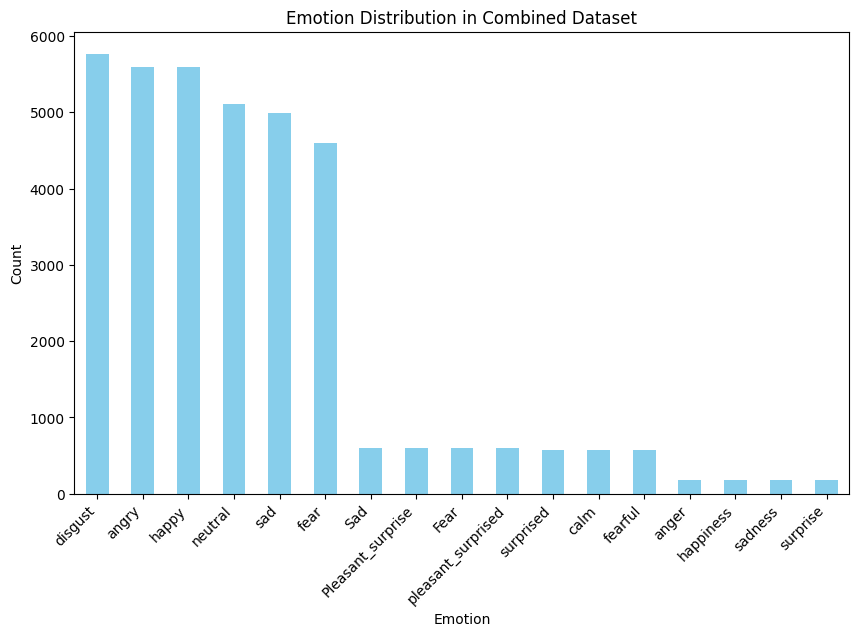

In [38]:
# prompt: NOW COUNT PLOT OF OVERALL

import pandas as pd
import matplotlib.pyplot as plt

# Load your extracted audio features from the CSV file
df_features = pd.read_csv('/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv')

# Count the occurrences of each emotion label
emotion_counts = df_features['Label'].value_counts()

# Plotting the distribution
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution in Combined Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [39]:
df['Label']



0           angry
1           angry
2           angry
3           happy
4           happy
           ...   
36481     neutral
36482     neutral
36483    surprise
36484    surprise
36485    surprise
Name: Label, Length: 36486, dtype: object

In [40]:
#function to plot loss and accuracy curves on training set
def plotgraph(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'firebrick',linewidth=3.0)
  plt.plot(history.history['accuracy'],'turquoise',linewidth=3.0)
  plt.legend(['Training loss','Training Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss and Accuracy',fontsize=16)
  plt.title('Loss Curves and Accuracy Curves',fontsize=16)


In [41]:


#function carries out additional preprocessing on data
#this function includes the EDA carried out on dataset
#the selected emotions are kept and others are dropped
#renaming of emotions is done to maintian uniformity
def additional_preprocess(filepath):
  #read the csv file of extrated features
  df = pd.read_csv(filepath)
  print("\nlabels or emotions present in dataset\n",df["Label"].unique())
  #replace label names with name common for each emotion
  #this is done to maintain uniformity of label names
  df["Label"] = df["Label"].str.replace("sadness", "sad", case = True)
  df["Label"] = df["Label"].str.replace("happiness", "happy", case = True)
  df["Label"] = df["Label"].str.replace("Fear", "fear", case = True)
  df["Label"] = df["Label"].str.replace("Sad", "sad", case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("fearful", "fear", case = True)
  df["Label"] = df["Label"].str.replace("anger", "angry", case = True)
  #drop labels surprized and clam
  #these label dosent contain sufficent amount of data and can lead to missclassification
  print("\nUnique count of labels or emotions\n",df["Label"].value_counts())
  #drop labels or emotions which can lead to misclassifications
  df.drop((np.where(df['Label'].isin(["surprise","calm"]))[0]), inplace = True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))
  return df

#this fucntion is used to get audio features perform one hot encoding and split datasets into train, test and validation
@calc_time
def audio_features_final():
  df = additional_preprocess("/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv")
  #get all the aduio features as numpy array from the dataframe
  #last column is label so last column is not fetched only 0to:-1
  data=df[df.columns[0:-1]].values
  #perform one hot encoding on labels
  encoder = OneHotEncoder()
  #fetch the last column of labels and perform one hot encoding on them
  label=df["Label"].values
  label = encoder.fit_transform(np.array(label).reshape(-1,1)).toarray()
  #min max scaler is used to normalize the data

  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)

  # After fitting the scaler:
  joblib.dump(scaler, 'scaler.pkl')




  #split the dataframe into train and test 80% train, 10% validation and 10% test datasets
  x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42,shuffle=True)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, shuffle=True)
  print("\nlength of train data is {}, test data is {} and validation set is {}".format(len(x_train),len(x_test),len(x_val)))
  print("\n shape of train features and label is {}".format(x_train.shape, y_train.shape))
  print("\n shape of test features and label is {}".format(x_test.shape, y_test.shape))
  print("\n shape of validation features and label is {}".format(x_val.shape,y_val.shape))
  return x_train, x_test, y_train, y_test, x_val, y_val, encoder



In [42]:
 additional_preprocess("/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv")


labels or emotions present in dataset
 ['angry' 'happy' 'sad' 'neutral' 'calm' 'surprised' 'fearful' 'disgust'
 'fear' 'Fear' 'Pleasant_surprise' 'Sad' 'pleasant_surprised' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 Label
angry       5769
happy       5769
sad         5769
disgust     5769
fear        5769
neutral     5109
surprise    1956
calm         576
Name: count, dtype: int64

Unique count of labels or emotions after dropping selected labels
 Label
angry      5769
happy      5769
sad        5769
fear       5769
disgust    5769
neutral    5109
Name: count, dtype: int64

length of the total data is 33954


0         1         2         3         4         5         6  \
0      0.213004  0.630638  0.591696  0.517308  0.534250  0.566880  0.636368   
1      0.311311  0.709949  0.732973  0.677279  0.678900  0.703226  0.702075   
2      0.199269  0.569841  0.620908  0.517952  0.522928  0.502488  0.639855   
3      0.252356  0.619311  0.588566  0.547787  0.569659  0.564923  0.583524   
4      0.323446  0.729002  0.702282  0.733570  0.760785  0.721938  0.668971   
...         ...       ...       ...       ...       ...       ...       ...   
36478  0.145300  0.756264  0.705023  0.677698  0.644325  0.653867  0.632884   
36479  0.036802  0.655997  0.665414  0.555904  0.490379  0.418461  0.401227   
36480  0.021581  0.560734  0.516350  0.517688  0.527408  0.564440  0.555831   
36481  0.102610  0.709006  0.704564  0.682025  0.674738  0.690819  0.678833   
36482  0.022103  0.564869  0.540417  0.499534  0.494767  0.535051  0.572712   

              7         8         9  ...        169        170          171  \
0      0.647355  0.679227  0.638586  ...  20.754897  45.435953  2157.194348   
1      0.658072  0.689507  0.684280  ...  15.362410  13.546320  3071.167905   
2      0.652675  0.622053  0.640868  ...  22.315534  48.425729  2148.234775   
3      0.654390  0.730218  0.688710  ...  19.009079  45.315156  2255.038164   
4      0.718139  0.710370  0.696126  ...  14.617361  13.549399  3148.304138   
...         ...       ...       ...  ...        ...        ...          ...   
36478  0.688595  0.715230  0.677599  ...  14.016211  13.446103  3284.287448   
36479  0.461949  0.599506  0.592193  ...  22.666525  51.461182  1471.344079   
36480  0.526604  0.547748  0.611942  ...  21.139109  46.144934  1372.635582   
36481  0.624622  0.635357  0.677412  ...  13.882584  13.379713  3317.582395   
36482  0.515034  0.478816  0.556808  ...  23.656358  49.199382  1335.685469   

            172       173       174       175       176       177    Label  
0     -0.050635  0.020029 -0.054833  0.020982  0.015229  0.009192    angry  
1     -0.032611  0.018618 -0.042520  0.017617  0.008769  0.000729    angry  
2     -0.006288 -0.039900 -0.045925 -0.027246  0.015053 -0.011725    angry  
3     -0.013308  0.021384  0.037566  0.012611 -0.002197  0.013762    happy  
4     -0.002037  0.029776  0.018962  0.029553  0.003772  0.010548    happy  
...         ...       ...       ...       ...       ...       ...      ...  
36478  0.002484 -0.006281  0.021740  0.056868 -0.014634  0.012030  neutral  
36479  0.013070  0.009114 -0.006564  0.054918  0.006373  0.009255  neutral  
36480  0.015654  0.006079 -0.048196  0.050548 -0.003750 -0.002737  neutral  
36481  0.001759  0.015859 -0.055231  0.027464 -0.007403  0.000221  neutral  
36482 -0.011148  0.027594 -0.051784 -0.060764 -0.008866  0.001021  neutral  

[33954 rows x 179 columns]


labels or emotions present in dataset
 ['angry' 'happy' 'sad' 'neutral' 'calm' 'surprised' 'fearful' 'disgust'
 'fear' 'Fear' 'Pleasant_surprise' 'Sad' 'pleasant_surprised' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 Label
angry       5769
happy       5769
sad         5769
disgust     5769
fear        5769
neutral     5109
surprise    1956
calm         576
Name: count, dtype: int64

Unique count of labels or emotions after dropping selected labels
 Label
angry      5769
happy      5769
sad        5769
fear       5769
disgust    5769
neutral    5109
Name: count, dtype: int64

length of the total data is 33954


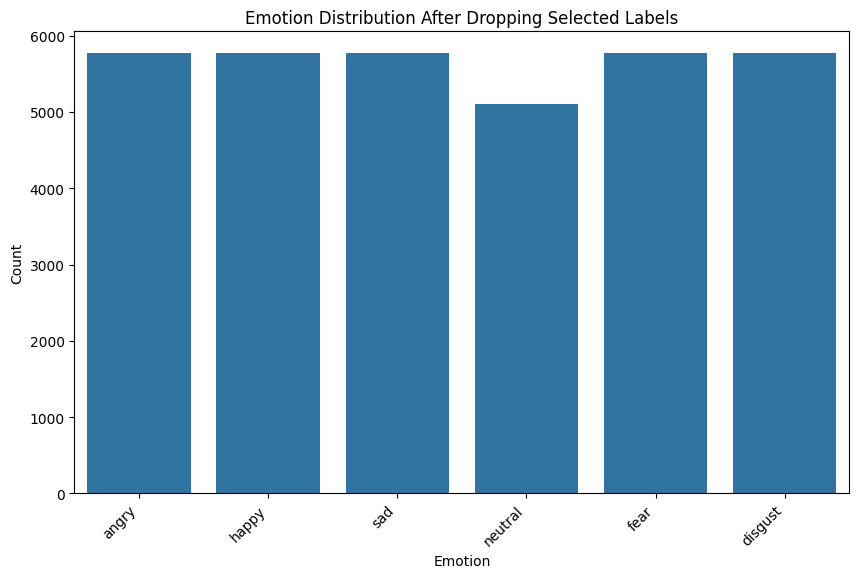

In [43]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the df DataFrame from your previous code
df = additional_preprocess("/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv")

# After dropping the labels, plot the unique label count using countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df)
plt.title('Emotion Distribution After Dropping Selected Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [60]:
import json
from tensorflow.keras.models import model_from_json

#fucntion trains the model and saves the best model at the checkpoint
@calc_time
def emotion_recognition_model(x_train,y_train,x_val,y_val):
  #reduce the laerning rate if plateau is encountered
  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
  #early stopping method is used to montior the loss if there are no significant reductions in loss then halt the training
  es = EarlyStopping(monitor='loss', patience=20)
  #checkpoint to save the best model with highest validation accuracy
  filepath = "/content/drive/MyDrive/Audiofiles/emotion-recognition.keras"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',)
  #create a combined list of reduce learning rate, early stopping and checkpoint
  callbacks_list = [reduce_lr,es,checkpoint]
  def residual_block(x, filters, conv_num=3, activation="relu"):
    #fucntion is used to create residual blocks and add residual blocks
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
      x = Conv1D(filters, 3, padding="same")(x)
      x = Activation(activation)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = Add()([x, s])
    x = Activation(activation)(x)
    return x
  #fucntion to build the model
  def build_model():
    inputs =  Input(shape=(x_train.shape[1],1))
    x = Dense(256, activation="relu")(inputs)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)
    #perform the average pooling after last residual block
    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(6, activation="softmax", name="output")(x)
    return Model(inputs=inputs, outputs=outputs)

  res_model = build_model()
  #display the summary of the model
  res_model.summary()
  #complie the model
  res_model.compile(loss='categorical_crossentropy',optimizer = Adam(learning_rate=1e-4, decay=1e-4 / 50) , metrics=['accuracy'])
  history = res_model.fit(np.expand_dims(x_train,-1),y_train,
                validation_data=(np.expand_dims(x_val, -1), y_val),
                epochs=500,
                batch_size=32,
                shuffle=True,

                verbose=1,

                callbacks = callbacks_list)
  # Save the model architecture to a JSON file

  print("Saved model to disk")



  #plot loss and accuracy curves
  plotgraph(history)

In [61]:
#this javascript is used to tell colab cell to open microphone and record audio
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""
#fucntion is used to invoke microphone on laptop and record the voice
#it used javascript to work as colab dosent have inbuilt method to record audio
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [72]:
#function is used to get the audio features recorded from the microphone


from tensorflow.keras.models import model_from_json
import json
from tensorflow.keras.models import load_model


def get_features_recorded(data,sr):

  #get features for recorded audio using mircophone
  res1 = extract_features(data,sr)
  result = np.array(res1)

  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sr)
  result = np.vstack((result, res2))

  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sr)
  res3 = extract_features(data_stretch_pitch,sr)
  result = np.vstack((result, res3))

  return result

#fucntion is used to evaualte performance of model on recorded audio using microphone
import os
import glob
@calc_time
def test_realtime(encoder):

  # #load the best model
  res_model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.keras")




  target_dir = '/content/drive/MyDrive/Audiofiles/realtimetested'
  if not os.path.exists(target_dir):
    print(f"Directory '{target_dir}' does not exist. Creating it...")
    os.makedirs(target_dir)  # Create the directory if it doesn't exist

  os.chdir(target_dir)

  #record the aduio
  audio, sr = get_audio()
  #save audio in a file
  files = []
  os.chdir('/content/drive/MyDrive/Audiofiles/realtimetested')
  for file in glob.glob("*.npy"):
	  files.append(file)

  #save the audio file for reference
  np.save('/content/drive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files)),audio)
  #plot the recorded audio
  plt.figure(figsize=(5,5))
  plt.plot(audio)
  plt.show()
  #save the plot of audio file
  plt.savefig("audiorec{}.png".format(len(files)))
  #convert int to float
  audio = audio.astype('float')
  #get audio features from the recorded voice
  feature = get_features_recorded(audio,sr)
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(feature)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  print("\nThe Emotion Predicted For Recorded Audio Using Microphone is {}".format(label_predicted[0]))
  #create a dataframe for recorded aduio features
  df = pd.DataFrame(index=range(0,3),columns=['path','label','audio'])
  for i in range(0,3):
    df["path"][i] = '/content/drive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files))
    df["label"][i] = label_predicted[i]
    df["audio"][i] = feature[i]

  #store the real time predicted features in a csv file
  df.to_csv('/content/drive/MyDrive/Audiofiles/realtimetested/real_time_predicted_audio_features.csv', mode='a', index=False)

#function to evaluate the model performance once the best model is saved
#it loads the best model and then evaluates the performance
@calc_time
def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.keras")
  #evaluate training accuracy
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")
  #predict the outcome of the model
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  #View the classification report for test data and predictions
  print("\nClassification report for Emotion Recognition")
  print(classification_report(y_test, y_pred))
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Emotion Recognition")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")


labels or emotions present in dataset
 ['angry' 'happy' 'sad' 'neutral' 'calm' 'surprised' 'fearful' 'disgust'
 'fear' 'Fear' 'Pleasant_surprise' 'Sad' 'pleasant_surprised' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 Label
angry       5769
happy       5769
sad         5769
disgust     5769
fear        5769
neutral     5109
surprise    1956
calm         576
Name: count, dtype: int64

Unique count of labels or emotions after dropping selected labels
 Label
angry      5769
happy      5769
sad        5769
fear       5769
disgust    5769
neutral    5109
Name: count, dtype: int64

length of the total data is 33954

length of train data is 27163, test data is 3395 and validation set is 3396

 shape of train features and label is (27163, 178)

 shape of test features and label is (3395, 178)

 shape of validation features and label is (3396, 178)
Total time required: 2068.772 ms


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 178, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 178, 256)       │            512 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 178, 16)        │         12,304 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 178, 16)        │              0 │ conv1d_51[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_52 (Conv1D)        │ (None, 178, 16)        │            784 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_50 (Conv1D)        │ (None, 178, 16)        │          4,112 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 178, 16)        │              0 │ conv1d_52[0][0],       │
│                           │                        │                │ conv1d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 178, 16)        │              0 │ add_14[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_54 (Conv1D)        │ (None, 178, 32)        │          1,568 │ activation_37[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 178, 32)        │              0 │ conv1d_54[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_55 (Conv1D)        │ (None, 178, 32)        │          3,104 │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_53 (Conv1D)        │ (None, 178, 32)        │            544 │ activation_37[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 178, 32)        │              0 │ conv1d_55[0][0],       │
│                           │                        │                │ conv1d_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 178, 32)        │              0 │ add_15[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_57 (Conv1D)        │ (None, 178, 32)        │          3,104 │ activation_39[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 178, 32)        │              0 │ conv1d_57[0][0]        │
│ (Activation)         

 Total params: 2,367,606 (9.03 MB)

 Trainable params: 2,367,606 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2799 - loss: 1.6592
Epoch 1: val_accuracy improved from -inf to 0.47703, saving model to /content/drive/MyDrive/Audiofiles/emotion-recognition.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.2800 - loss: 1.6591 - val_accuracy: 0.4770 - val_loss: 1.2943 - learning_rate: 1.0000e-04
Epoch 2/500
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5027 - loss: 1.2332
Epoch 2: val_accuracy improved from 0.47703 to 0.53769, saving model to /content/drive/MyDrive/Audiofiles/emotion-recognition.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5027 - loss: 1.2332 - val_accuracy: 0.5377 - val_loss: 1.1543 - learning_rate: 1.0000e-04
Epoch 3/500
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5408 - loss: 1.1448
Epoch 3: val_accuracy improved from 0.53769 to 0.55359, saving model to /content/drive/MyDrive/Audiofiles/emotion-recognition.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accu

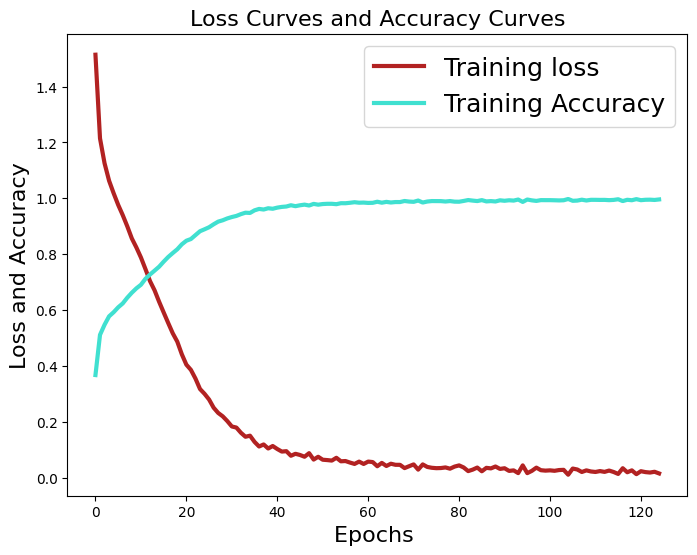

In [63]:
#function calculates the above code in sequence
#it runs the model and also evaluates the model performance
@calc_time
def main():
  #get train,test data and labels
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model
  emotion_recognition_model(x_train,y_train,x_val,y_val)
  #evaluate the model performance
  evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val)

if __name__:main()


**1 hr training**

In [64]:
x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()


labels or emotions present in dataset
 ['angry' 'happy' 'sad' 'neutral' 'calm' 'surprised' 'fearful' 'disgust'
 'fear' 'Fear' 'Pleasant_surprise' 'Sad' 'pleasant_surprised' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 Label
angry       5769
happy       5769
sad         5769
disgust     5769
fear        5769
neutral     5109
surprise    1956
calm         576
Name: count, dtype: int64

Unique count of labels or emotions after dropping selected labels
 Label
angry      5769
happy      5769
sad        5769
fear       5769
disgust    5769
neutral    5109
Name: count, dtype: int64

length of the total data is 33954

length of train data is 27163, test data is 3395 and validation set is 3396

 shape of train features and label is (27163, 178)

 shape of test features and label is (3395, 178)

 shape of validation features and label is (3396, 178)
Total time required: 2141.447 ms


In [65]:
#mapping of the one hot ecoding with respect to their labels
print("\none hot encoding array\n",np.unique(y_train,axis=0))
print("\nOne hot encoding mapping to actual label\n",encoder.inverse_transform(np.unique(y_train,axis=0)))


one hot encoding array
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]

One hot encoding mapping to actual label
 [['sad']
 ['neutral']
 ['happy']
 ['fear']
 ['disgust']
 ['angry']]


In [66]:
import pandas as pd
import numpy as np

# Assuming you have the one-hot encoding array and emotion labels:
one_hot_array = np.unique(y_train, axis=0)
emotion_labels = ['sad', 'neutral', 'happy', 'fear', 'disgust', 'angry']

# Convert the 2D one-hot array into a list of lists:
one_hot_list = one_hot_array.tolist()  # Convert to a list of lists

# Create the DataFrame using the list of lists:
df2 = pd.DataFrame({'One-Hot Encoding Array': one_hot_list,
                   'Encoding Mapping to Actual Label': emotion_labels})

print(df2)

           One-Hot Encoding Array Encoding Mapping to Actual Label
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]                              sad
1  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]                          neutral
2  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]                            happy
3  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]                             fear
4  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]                          disgust
5  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]                            angry


In [68]:
import os
os.getcwd()

'/content/drive/MyDrive/Audiofiles'

In [67]:
# prompt: what changes  do i have to made to save the encoder pickl

import pickle

# Save the encoder to a pickle file
with open('encoder.pickle', 'wb') as f:
  pickle.dump(encoder, f)

# Later, you can load the encoder from the pickle file:
with open('encoder.pickle', 'rb') as f:
  encoder = pickle.load(f)

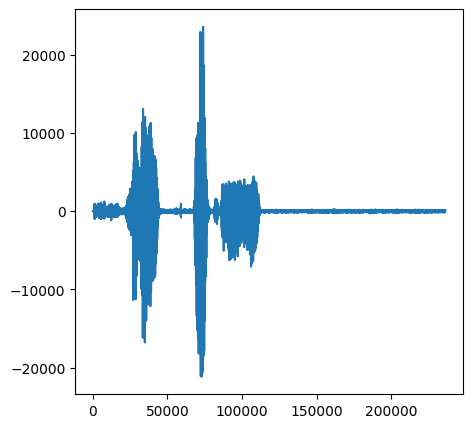

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step

The Emotion Predicted For Recorded Audio Using Microphone is ['neutral']
Total time required: 14143.362 ms


<Figure size 640x480 with 0 Axes>

In [78]:
#this function call is used to record audio using microphone and test the model in real time on speaker voice
test_realtime(encoder)

In [91]:
from google.colab import files
from io import BytesIO
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import pickle

#@title Upload Audio File
uploaded = files.upload()



def extract_features(data, sample_rate):
    result = np.array([])
    # Extract features
    try:
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(data)), sr=sample_rate).T, axis=0)
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
        centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
        # Concatenate all features
        result = np.hstack((result, zcr, chroma_stft, mfcc, rms, mel, rolloff, centroid, contrast, bandwidth, tonnetz))
    except Exception as e:
        st.error(f"Feature extraction error: {e}")
    return result

# Load the model and scaler
model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.keras")
with open('/content/drive/MyDrive/Audiofiles/scaler.pkl', 'rb') as f:
  scaler = joblib.load(f)

with open('/content/drive/MyDrive/Audiofiles/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Load the audio file
  # Replace this with your actual audio loading logic
  # (e.g., using librosa.load())
  data, sr = librosa.load(BytesIO(uploaded[fn]))

  # Extract features
  features = extract_features(data, sr)
  features = np.array(features).reshape(1, -1)

  # Apply MinMax scaling
  features_scaled = scaler.transform(features)

  # Make a prediction
  prediction = model.predict(features_scaled)

  # Decode the one-hot encoded prediction using the saved encoder
  label_predicted = encoder.inverse_transform(prediction)

  print("\nThe Emotion Predicted is {}".format(label_predicted[0]))

Saving OAF_back_happy.wav to OAF_back_happy.wav
User uploaded file "OAF_back_happy.wav" with length 97758 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step

The Emotion Predicted is ['happy']


In [ ]:
## GUI

from tkinter import *
import tkinter.filedialog as filedialog
import tkinter.messagebox as messagebox
import numpy as np
import pyaudio
import wave
import threading
import librosa
from pydub import AudioSegment, effects
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import model_from_json
import librosa
import numpy as np
import tkinter as tk
import pyaudio
import wave
import threading
import tkinter.filedialog as tk_filedialog


 #Load the model architecture from JSON file


#Load the model weights from .h5 file
# model2.load_weights("model2.weights.h5")

 #Compile the model (necessary after loading)



import pickle


# with open('encoder.pkl', 'rb') as f:
#     encoder = pickle.load(f)

def extract_mfcc():
    pass


class SPEECHPROJECT:
    def __init__(self):
        self.window = Tk()
        self.window.geometry("800x800")  # Set fixed size of the window
        self.window.resizable(False, False)  # Disable resizing of the window
        self.main_window()

        # Initialize audio recording attributes
        self.is_recording = False
        self.audio_frames = []
        self.filename = None  # For storing the file path

        # Add menu
        self.mainmenu = Menu(self.window)
        self.filemenu = Menu(self.mainmenu, tearoff=0)
        self.mainmenu.add_cascade(label='File', menu=self.filemenu)
        self.filemenu.add_command(label='Exit', command=self.window.destroy)
        self.viewmenu = Menu(self.mainmenu, tearoff=0)
        self.viewmenu.add_command(label='Help', command=self.onclickhelp)
        self.viewmenu.add_command(label='About', command=self.about)
        self.mainmenu.add_cascade(label='View', menu=self.viewmenu)
        self.window.config(menu=self.mainmenu)



    def about(self):
        messagebox.showinfo("Info", "This application is developed by G41")

    def onclickhelp(self):
        messagebox.showinfo("Help", "This is a python prototype application for minor project.")

    def main_window(self):
        self.window.title("G41 Emotion in Speech Recognition")
        self.window.configure(bg="#000")
        head_label = Label(self.window, bg="#000", fg="#FFF", text="G41 Emotion in Speech", font="Melvetica 26 bold")
        #head_label.place(relx=0.5, rely=0.5, anchor=CENTER) # Centers using relx, rely, anchor
        head_label.place(relwidth=1 )

        # Create a frame for the Text widget
        text_frame = Frame(self.window)
        text_frame.place(relheight=0.7, relwidth=1, rely=0.08)

        # Text widget for output only
        self.text_widget = Text(text_frame, bg="#fff", fg="#000", font="Melvetica 14", padx=5, pady=5)
        self.text_widget.pack(side=LEFT, fill=BOTH, expand=True)



        self.text_widget.configure(state=DISABLED)  # Make the Text widget read-only

        # Bottom section for buttons
        bottom_label = Label(self.window, bg="#ABB2B9", height=80)
        bottom_label.place(relwidth=1, rely=0.825)

        # Record button
        self.record_button = Button(bottom_label, text="Record", font="Melvetica 13 bold", width=15, bg="#fff",
                                    command=self.start_recording)
        self.record_button.place(relx=0.05, rely=0.008, relheight=0.06, relwidth=0.15)

        # Stop button
        self.stop_button = Button(bottom_label, text="Stop", font="Melvetica 13 bold", width=15, bg="#fff",
                                  state=DISABLED, command=self.stop_recording)
        self.stop_button.place(relx=0.25, rely=0.008, relheight=0.06, relwidth=0.15)

        # Browse button
        self.browse_button = Button(bottom_label, text="Browse", font="Melvetica 13 bold", width=15, bg="#fff",
                                    command=self.browse_file)
        self.browse_button.place(relx=0.45, rely=0.008, relheight=0.06, relwidth=0.15)

        # Predict button
        self.predict_button = Button(bottom_label, text="Predict Emotion", font="Melvetica 13 bold", width=15, bg="#fff",
                                     state=DISABLED, command=self.predict_emotion)
        self.predict_button.place(relx=0.65, rely=0.008, relheight=0.06, relwidth=0.30)

    def start_recording(self):
        pass

    def _record(self):
        pass
    def stop_recording(self):
        pass


        #Save recorded audio




    def browse_file(self):
        filename = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav;*.mp3;*.ogg")])
        if filename:  # If a file is selected
            self.filename = filename  # Update the filename attribute

            # Extract filename only using 'os.path.basename'
            import os
            filename_only = os.path.basename(self.filename)

            self.update_text_widget(f"\nSelected file: {filename_only}")
        # Enable Predict button regardless of file selection
        self.predict_button.config(state=NORMAL)

    def update_text_widget(self, message):
        self.text_widget.config(state=NORMAL)
        self.text_widget.insert(END, message + "\n")  # Append new message with a newline
        self.text_widget.config(state=DISABLED)
        self.text_widget.see(END)  # Scroll to the end




    def predict_emotion(self):
        pass

    def run(self):
        self.window.mainloop()

# Run the application
if __name__ == "__main__":
    LT = SPEECHPROJECT()
    LT.run()

In [79]:
import sys
sys.version

'3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]'

In [80]:
# pip list of colab

def list_colab_packages():
  """Lists the installed packages in Google Colab."""
  !pip freeze

list_colab_packages()

absl-py==1.4.0
accelerate==0.34.2
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.4
astropy-iers-data==0.2024.10.28.0.34.7
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.25.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1